1. create conda env and activate
2. install 3.8.11 in conda env
3. install pip
4. install reqs

In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training')) #needed for ai8x module to be loaded
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/models'))


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from torchvision.io import read_image
import ai8x
from distiller import apputils
import pandas as pd
import matplotlib.pyplot as plt
import datasets.memes as memes
import numpy as np
from models import memenet
import parse_qat_yaml


def printstats(variable):
    print("Shape: ", variable.shape)
    print("Max: ", variable.max())
    print("Min: ", variable.min())
    print("Mean: ", variable.mean())
    print("Variance: ", variable.var())
    



def infer(model, input_img):
    sample_input = input_img #expected quant input range -128 to 127/128
    sample_output_model = model(sample_input.unsqueeze(0)) #output range -1 to 1
    
    sample_output = 255*(sample_output_model+1)/2 #output range 0 to 255

    in_img = sample_input.permute(1,2,0) #0-255
    out_img = sample_output.squeeze(0).permute(1,2,0) #0-255
    
    mse = torch.nn.MSELoss()
    mse = np.round(mse(sample_input,sample_output_model).item(), 4)
                   
    return in_img, out_img, mse


%matplotlib inline

torch.Size([1, 32, 32])


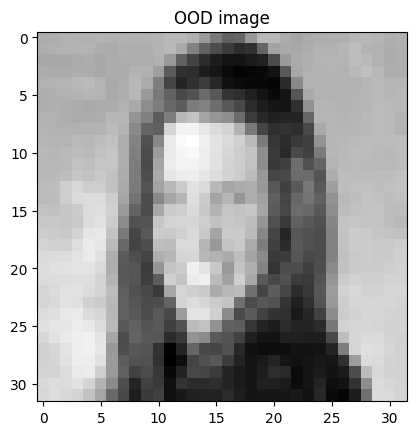

In [2]:
#read ood.png image 
ood_img = read_image('../ai8x-training/data/memes/test/ood.png')
#convert from png to rgb
ood_img = transforms.functional.to_pil_image(ood_img)
ood_img = transforms.functional.to_grayscale(ood_img, num_output_channels=1)
ood_img = transforms.functional.resize(ood_img, (32,32))
ood_img = transforms.functional.to_tensor(ood_img)

plt.title("OOD image")
plt.imshow(ood_img.squeeze(), cmap='gray')
print(ood_img.shape)

### Expected Data Range

For training, input data is expected to be in the range  . When evaluating quantized weights, or when running on hardware, input data is instead expected to be in the native MAX7800X range of [-128, +127].

As described in the following sections, the data loader function takes the data path and some arguments as input arguments. The arguments field includes two required fields, act_mode_8bit and truncate_testset. When set to True, the first argument refers to the case normalization should be done correctly for the native MAX7800X range, i.e., to range [-128, +127]. When set to False, the normalization should be in the range of  for training.

If the available data is in the range of [0 1], e.g., as in PIL images, the data loader can directly call the ai8x.normalize() function to normalize the data to the two supported data ranges using the provided args argument:

class normalize:
"""
Normalize input to either [-128/128, +127/128] or [-128, +127]
"""
    def __init__(self, args):
        self.args = args

    def __call__(self, img):
        if self.args.act_mode_8bit:
            return img.sub(0.5).mul(256.).round().clamp(min=-128, max=127)
        return img.sub(0.5).mul(256.).round().clamp(min=-128, max=127).div(128.)

If the available data range is [0 255], it needs to be divided by 256 to bring it to the [0 1] range before calling the ai8x.normalize() function.

Note: The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. This method is used by training scripts with proper argument management, but if one calls the function externally, the simulate parameter should be set correctly.

When running inference on the MAX7800X hardware, it is essential to take the native data format into account, and it is desirable to perform as little preprocessing as possible during inference.



# Test on non quant model

In [3]:
#check dataloader
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit #IMPORTANT: SET CORRECTLY!!!!!!!!
        self.truncate_testset = False 

args = Args(act_mode_8bit=False) #IMPORTANT: if this is not set to true, the test set will be float instead of int, and so you can't use the quantized model
data_path = os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/data')

ds_train,ds_test = memes.memes_get_datasets((data_path, args), load_train=True, load_test=True)

printstats(ds_train[2][1])

Shape:  torch.Size([1, 32, 32])
Max:  tensor(0.9062)
Min:  tensor(-1.)
Mean:  tensor(-0.5778)
Variance:  tensor(0.3017)


Configuring device: MAX78000, simulate=False.


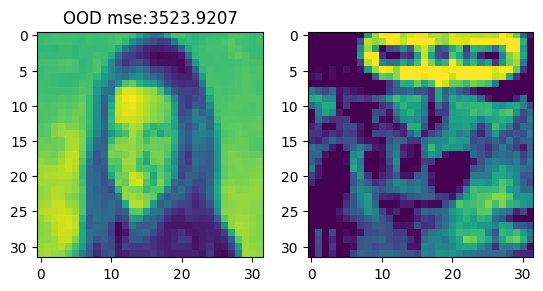

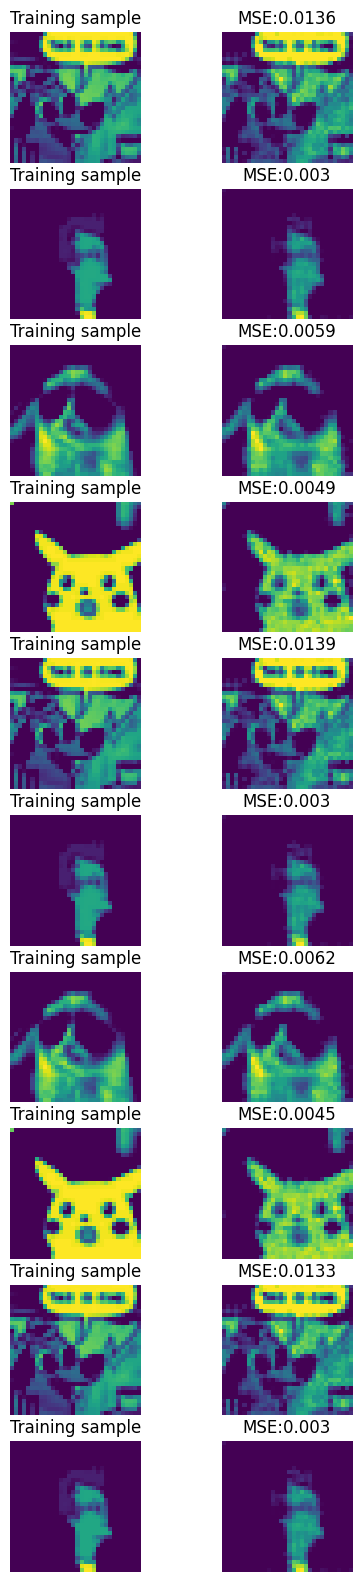

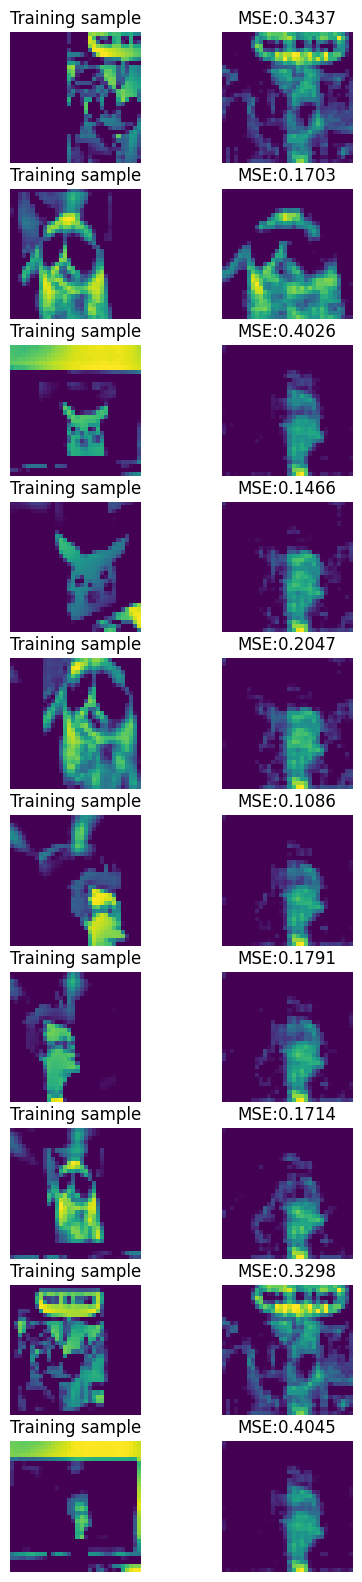

In [4]:
#ai8x.set_device(85, True, True)  #IMPORTANT: SET SIMULATE PARAM, AS IT WILL OVERRIDE 8bit PARAM !!!!!!!! 
ai8x.set_device(85, False, True)  #use if non quant (ai8x.set_device(85, False, False) if not using -q file)

#The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. 

model = memenet.MemeNet(num_channels=1, dimensions=(32,32))
checkpoint_path = '../ai8x-synthesis/trained/qat_best.pth.tar'
model = apputils.load_lean_checkpoint(model, checkpoint_path)
ai8x.update_model(model)


model.eval()
with torch.no_grad():
    
    sample_input2 = 255*(ood_img)-127 #convert PIL 0-1 to  input range -127 to 128
    in_img2, out_img2, mse = infer(model, sample_input2)
    
    fig2, ax2 = plt.subplots(1,2)
    ax2[0].imshow(in_img2)
    ax2[1].imshow(out_img2)
    ax2[0].set_title('OOD sample')
    ax2[0].set_title('OOD mse:%s'% mse)
    
    if True:
        #training set
        fig , ax= plt.subplots(10,2)
        fig.set_figheight(20)
        fig.set_figwidth(5)
        for i in range(10):
            idx=i
            sample_input = ds_train[idx][0] # input from -1 to 1 is expected
            in_img, out_img, mse = infer(model, sample_input)

            ax[i][0].imshow(in_img)
            ax[i][1].imshow(out_img)
            ax[i][0].axis('off')
            ax[i][1].axis('off')
            #title ax
            ax[i][0].set_title('Training sample')
            ax[i][1].set_title('MSE:%s'%mse)
            
    if True:
        #test set
        fig , ax= plt.subplots(10,2)
        fig.set_figheight(20)
        fig.set_figwidth(5)
        for i in range(10):
            idx=i
            sample_input = ds_test[idx][0] # input from -1 to 1 is expected
            in_img, out_img, mse = infer(model, sample_input)

            ax[i][0].imshow(in_img)
            ax[i][1].imshow(out_img)
            ax[i][0].axis('off')
            ax[i][1].axis('off')
            #title ax
            ax[i][0].set_title('Training sample')
            ax[i][1].set_title('MSE:%s'%mse)
        

### Test set evaluation of the quantized model

In [5]:
#check dataloader
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit #IMPORTANT: SET CORRECTLY!!!!!!!!
        self.truncate_testset = False 

args = Args(act_mode_8bit=True) #IMPORTANT: set to TRUE for quantization
data_path = os.path.join(os.path.dirname(os.getcwd()), 'ai8x-training/data')

ds_train,ds_test = memes.memes_get_datasets((data_path, args), load_train=True, load_test=True)

printstats(ds_train[2][1])

Shape:  torch.Size([1, 32, 32])
Max:  tensor(114.)
Min:  tensor(-128.)
Mean:  tensor(-73.9883)
Variance:  tensor(4933.3838)


Configuring device: MAX78000, simulate=True.
{'start_epoch': 6, 'weight_bits': 4}


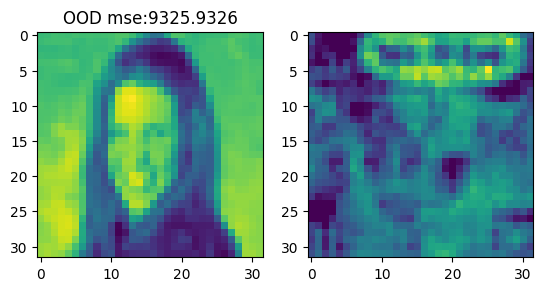

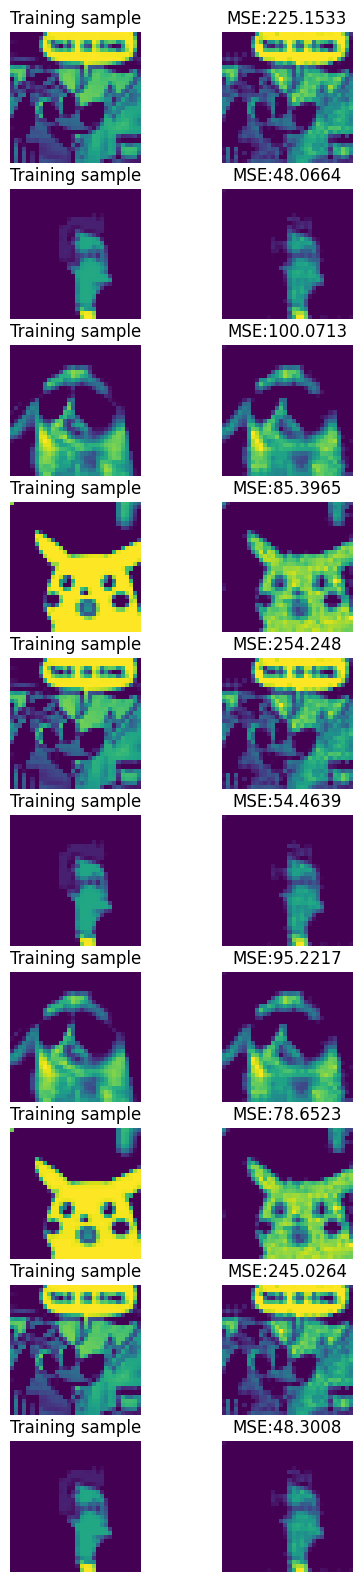

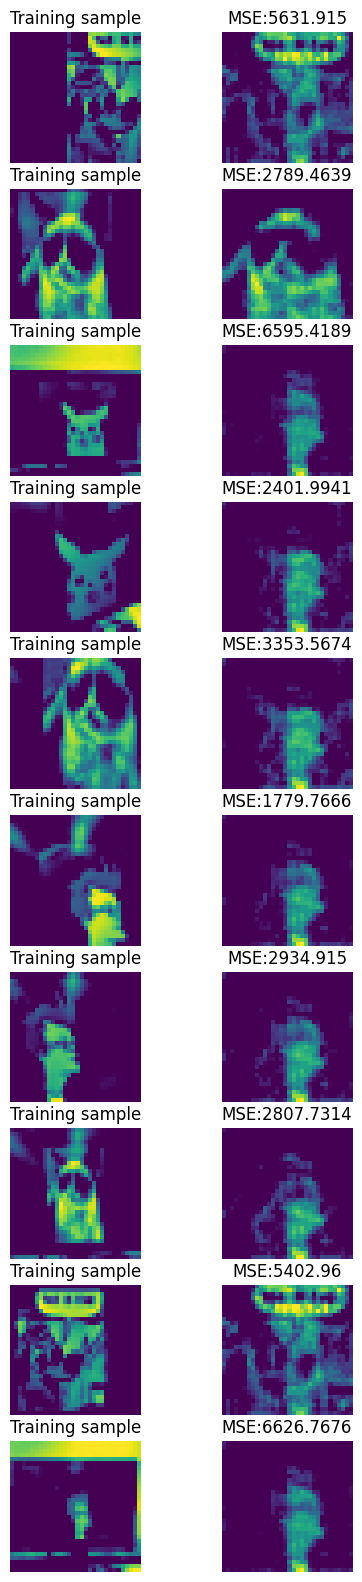

In [6]:
#ai8x.set_device(85, True, True)  #IMPORTANT: SET SIMULATE PARAM, AS IT WILL OVERRIDE 8bit PARAM !!!!!!!! 
ai8x.set_device(85, True, True)  #use if quant

#The device setting method ai8x.set_device of the ai8x module also accepts a related parameter simulate: 
# True for the training case (act_mode_8bit = True) and False for the evaluation of quantized model or running on hardware that also initializes act_mode_8bit = False. 

model = memenet.MemeNet(num_channels=1, dimensions=(32,32))

# Switch model from unquantized to quantized for QAT
qat_yaml_file_used_in_training = '../ai8x-training/policies/qat_policy_memenet.yaml'
qat_policy = parse_qat_yaml.parse(qat_yaml_file_used_in_training)
ai8x.initiate_qat(model, qat_policy)


checkpoint_path = '../ai8x-synthesis/trained/qat_best-q.pth.tar'
model = apputils.load_lean_checkpoint(model, checkpoint_path)
ai8x.update_model(model)


model.eval()
with torch.no_grad():
    sample_input2 = 255*(ood_img)-127 #convert PIL 0-1 to  input range -127 to 128
    in_img2, out_img2, mse = infer(model, sample_input2)

    fig2, ax2 = plt.subplots(1,2)
    ax2[0].imshow(in_img2)
    ax2[1].imshow(out_img2)
    ax2[0].set_title('OOD sample')
    ax2[0].set_title('OOD mse:%s'% mse)
    
    if True:
        #training set
        fig , ax= plt.subplots(10,2)
        fig.set_figheight(20)
        fig.set_figwidth(5)
        for i in range(10):
            idx=i
            sample_input = ds_train[idx][0] #expected quant input range -128 to 127/128
            in_img, out_img, mse = infer(model, sample_input)
            
            ax[i][0].imshow(in_img)
            ax[i][1].imshow(out_img)
            ax[i][0].axis('off')
            ax[i][1].axis('off')
            #title ax
            ax[i][0].set_title('Training sample')
            ax[i][1].set_title('MSE:%s'%mse)
            
            
    if True:
        #test set
        fig , ax= plt.subplots(10,2)
        fig.set_figheight(20)
        fig.set_figwidth(5)
        for i in range(10):
            idx=i
            
            sample_input = ds_test[idx][0] #expected quant input range -128 to 127/128
            in_img, out_img, mse = infer(model, sample_input)
            
            ax[i][0].imshow(in_img)
            ax[i][1].imshow(out_img)
            ax[i][0].axis('off')
            ax[i][1].axis('off')
            #title ax
            ax[i][0].set_title('Training sample')
            ax[i][1].set_title('MSE:%s'%mse)

Shape:  (1, 32, 32)
Max:  18
Min:  -128
Mean:  -93.61328125
Variance:  2486.5418548583984
MSE:  2871.3057


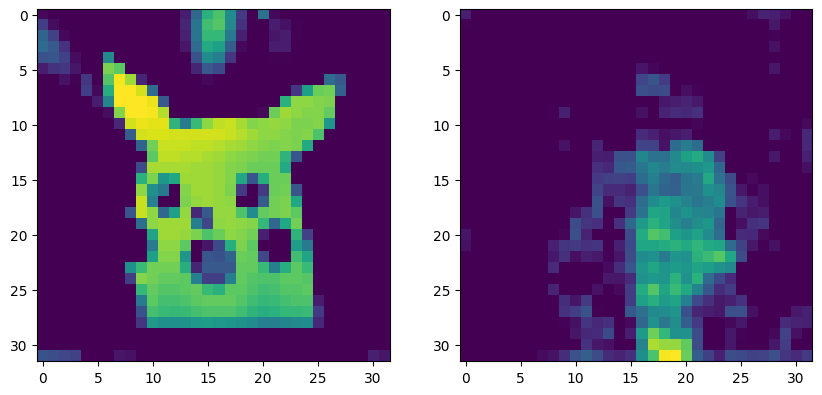

In [7]:
sample_to_load_on_uc = "../ai8x-synthesis/tests/sample_memes.npy"
sample = np.load(sample_to_load_on_uc)
#conver to -127 to 128 range
printstats(sample)

#plot
fig , ax= plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
ax[0].imshow(sample.squeeze())

model_input = torch.FloatTensor(sample).unsqueeze(0)


ax[1].imshow(model(model_input).squeeze().detach().numpy())


mse = torch.nn.MSELoss()
mse = np.round(mse(model_input,model(model_input)).item(), 4)
print("MSE: ", mse)

In [8]:
uc_output = '''Data mismatch (1/1024) at address 0x50400000: Expected 0x00808ea3, read 0x00fd0409.
Data mismatch (2/1024) at address 0x50400004: Expected 0x00808080, read 0x00f20203.
Data mismatch (3/1024) at address 0x50400008: Expected 0x00808080, read 0x00f00a0f.
Data mismatch (4/1024) at address 0x5040000c: Expected 0x00808080, read 0x00f40606.
Data mismatch (5/1024) at address 0x50400010: Expected 0x00808080, read 0x00020b0b.
Data mismatch (6/1024) at address 0x50400014: Expected 0x00808080, read 0x00fafe05.
Data mismatch (7/1024) at address 0x50400018: Expected 0x00808080, read 0x00f6ff06.
Data mismatch (8/1024) at address 0x5040001c: Expected 0x00808080, read 0x00e8f800.
Data mismatch (9/1024) at address 0x50400020: Expected 0x00808080, read 0x00d8f2fd.
Data mismatch (10/1024) at address 0x50400024: Expected 0x00808080, read 0x00d4f0f7.
Data mismatch (11/1024) at address 0x50400028: Expected 0x00808080, read 0x00def6fe.
Data mismatch (12/1024) at address 0x5040002c: Expected 0x00808080, read 0x00ec030b.
Data mismatch (13/1024) at address 0x50400030: Expected 0x00808080, read 0x00dc0a15.
Data mismatch (14/1024) at address 0x50400034: Expected 0x00808080, read 0x00c4f51b.
Data mismatch (15/1024) at address 0x50400038: Expected 0x00808080, read 0x0086bee7.
Data mismatch (16/1024) at address 0x5040003c: Expected 0x00808080, read 0x0080abed.
Data mismatch (17/1024) at address 0x50400040: Expected 0x00808080, read 0x0080a0dc.
Data mismatch (18/1024) at address 0x50400044: Expected 0x00808080, read 0x008080b8.
Data mismatch (21/1024) at address 0x50400050: Expected 0x00808080, read 0x00a8c6d1.
Data mismatch (22/1024) at address 0x50400054: Expected 0x00808080, read 0x00bee000.
Data mismatch (23/1024) at address 0x50400058: Expected 0x00808080, read 0x0083afd2.
Data mismatch (24/1024) at address 0x5040005c: Expected 0x00808080, read 0x008080a5.
Data mismatch (27/1024) at address 0x50400068: Expected 0x00808080, read 0x00809bba.
Data mismatch (28/1024) at address 0x5040006c: Expected 0x00808080, read 0x0080e621.
Data mismatch (29/1024) at address 0x50400070: Expected 0x00808080, read 0x0080c817.
Data mismatch (30/1024) at address 0x50400074: Expected 0x00808082, read 0x008091f7.
Data mismatch (31/1024) at address 0x50400078: Expected 0x00808080, read 0x008080ba.
Data mismatch (32/1024) at address 0x5040007c: Expected 0x00808080, read 0x008080af.
Data mismatch (33/1024) at address 0x50400080: Expected 0x00808080, read 0x00dd1420.
Data mismatch (34/1024) at address 0x50400084: Expected 0x00808080, read 0x00b7162a.
Data mismatch (35/1024) at address 0x50400088: Expected 0x00808080, read 0x009f0f26.
Data mismatch (36/1024) at address 0x5040008c: Expected 0x00808080, read 0x00b90811.
Data mismatch (37/1024) at address 0x50400090: Expected 0x00808080, read 0x00f6100d.
Data mismatch (38/1024) at address 0x50400094: Expected 0x00808080, read 0x00061017.
Data mismatch (39/1024) at address 0x50400098: Expected 0x00808080, read 0x000c131a.
Data mismatch (40/1024) at address 0x5040009c: Expected 0x00808080, read 0x00fb0810.
Data mismatch (41/1024) at address 0x504000a0: Expected 0x00808080, read 0x00f1070f.
Data mismatch (42/1024) at address 0x504000a4: Expected 0x00808080, read 0x00fc0e10.
Data mismatch (43/1024) at address 0x504000a8: Expected 0x00808080, read 0x00171915.
Data mismatch (44/1024) at address 0x504000ac: Expected 0x00808080, read 0x00302825.
Data mismatch (45/1024) at address 0x504000b0: Expected 0x00808080, read 0x00040b16.
Data mismatch (46/1024) at address 0x504000b4: Expected 0x00808080, read 0x00c3e318.
Data mismatch (47/1024) at address 0x504000b8: Expected 0x00808080, read 0x008080c7.
Data mismatch (48/1024) at address 0x504000bc: Expected 0x00808080, read 0x0080a005.
Data mismatch (49/1024) at address 0x504000c0: Expected 0x00808080, read 0x0080a200.
Data mismatch (50/1024) at address 0x504000c4: Expected 0x00808080, read 0x0080aef8.
Data mismatch (51/1024) at address 0x504000c8: Expected 0x00808080, read 0x008085b2.
Data mismatch (52/1024) at address 0x504000cc: Expected 0x00808080, read 0x008096b2.
Data mismatch (53/1024) at address 0x504000d0: Expected 0x00808080, read 0x00cbc6d6.
Data mismatch (54/1024) at address 0x504000d4: Expected 0x00808080, read 0x0092b2c8.
Data mismatch (55/1024) at address 0x504000d8: Expected 0x00808080, read 0x008080a5.
Data mismatch (56/1024) at address 0x504000dc: Expected 0x00808080, read 0x00808093.
Data mismatch (59/1024) at address 0x504000e8: Expected 0x00808080, read 0x0080aeea.
Data mismatch (60/1024) at address 0x504000ec: Expected 0x00808080, read 0x0080f659.
Data mismatch (61/1024) at address 0x504000f0: Expected 0x00808080, read 0x0080981f.
Data mismatch (62/1024) at address 0x504000f4: Expected 0x00808080, read 0x0080801a.
Data mismatch (63/1024) at address 0x504000f8: Expected 0x00808080, read 0x00808003.
Data mismatch (64/1024) at address 0x504000fc: Expected 0x00808080, read 0x0080980a.
Data mismatch (65/1024) at address 0x50400100: Expected 0x00808080, read 0x00b42240.
Data mismatch (66/1024) at address 0x50400104: Expected 0x00808080, read 0x00800d3a.
Data mismatch (67/1024) at address 0x50400108: Expected 0x00808080, read 0x00800334.
Data mismatch (68/1024) at address 0x5040010c: Expected 0x00808080, read 0x0080dbee.
Data mismatch (69/1024) at address 0x50400110: Expected 0x00808080, read 0x00ce00ff.
Data mismatch (70/1024) at address 0x50400114: Expected 0x00808080, read 0x000c171d.
Data mismatch (71/1024) at address 0x50400118: Expected 0x00808080, read 0x000b1314.
Data mismatch (72/1024) at address 0x5040011c: Expected 0x00808080, read 0x00071119.
Data mismatch (73/1024) at address 0x50400120: Expected 0x00808080, read 0x00fe1518.
Data mismatch (74/1024) at address 0x50400124: Expected 0x00808080, read 0x00102d25.
Data mismatch (75/1024) at address 0x50400128: Expected 0x00808080, read 0x00323829.
Data mismatch (76/1024) at address 0x5040012c: Expected 0x00808080, read 0x00434d2c.
Data mismatch (77/1024) at address 0x50400130: Expected 0x00808080, read 0x00ef080c.
Data mismatch (78/1024) at address 0x50400134: Expected 0x00808080, read 0x00809bd7.
Data mismatch (79/1024) at address 0x50400138: Expected 0x00808080, read 0x008080b7.
Data mismatch (80/1024) at address 0x5040013c: Expected 0x00808080, read 0x00808d01.
Data mismatch (81/1024) at address 0x50400140: Expected 0x00808080, read 0x0080b616.
Data mismatch (82/1024) at address 0x50400144: Expected 0x00808080, read 0x0080dd2f.
Data mismatch (83/1024) at address 0x50400148: Expected 0x00808080, read 0x0092e0f8.
Data mismatch (84/1024) at address 0x5040014c: Expected 0x00808080, read 0x00dffa03.
Data mismatch (85/1024) at address 0x50400150: Expected 0x00808080, read 0x00b2d6c7.
Data mismatch (90/1024) at address 0x50400164: Expected 0x00808080, read 0x008080a8.
Data mismatch (91/1024) at address 0x50400168: Expected 0x00808080, read 0x0080d915.
Data mismatch (92/1024) at address 0x5040016c: Expected 0x00808080, read 0x00800562.
Data mismatch (93/1024) at address 0x50400170: Expected 0x00808080, read 0x0080c63c.
Data mismatch (94/1024) at address 0x50400174: Expected 0x00808080, read 0x0080c358.
Data mismatch (95/1024) at address 0x50400178: Expected 0x00808080, read 0x0080ca48.
Data mismatch (96/1024) at address 0x5040017c: Expected 0x00808080, read 0x0080d43c.
Data mismatch (97/1024) at address 0x50400180: Expected 0x00808080, read 0x00800d3c.
Data mismatch (98/1024) at address 0x50400184: Expected 0x00808080, read 0x0080055a.
Data mismatch (99/1024) at address 0x50400188: Expected 0x00808080, read 0x0080e52b.
Data mismatch (100/1024) at address 0x5040018c: Expected 0x00808080, read 0x0080a4d2.
Data mismatch (101/1024) at address 0x50400190: Expected 0x00808080, read 0x00a8cce2.
Data mismatch (102/1024) at address 0x50400194: Expected 0x00808080, read 0x00fc0a13.
Data mismatch (103/1024) at address 0x50400198: Expected 0x00808080, read 0x00f1fb02.
Data mismatch (104/1024) at address 0x5040019c: Expected 0x00808080, read 0x00f90b16.
Data mismatch (105/1024) at address 0x504001a0: Expected 0x00808080, read 0x00062629.
Data mismatch (106/1024) at address 0x504001a4: Expected 0x00808080, read 0x0025453f.
Data mismatch (107/1024) at address 0x504001a8: Expected 0x00808080, read 0x00262816.
Data mismatch (108/1024) at address 0x504001ac: Expected 0x00808080, read 0x000a09db.
Data mismatch (109/1024) at address 0x504001b0: Expected 0x00808080, read 0x00afbfc3.
Data mismatch (110/1024) at address 0x504001b4: Expected 0x00808080, read 0x00808098.
Data mismatch (111/1024) at address 0x504001b8: Expected 0x00808080, read 0x008080bc.
Data mismatch (112/1024) at address 0x504001bc: Expected 0x00808080, read 0x008092fa.
Data mismatch (113/1024) at address 0x504001c0: Expected 0x00808080, read 0x0080c117.
Data mismatch (114/1024) at address 0x504001c4: Expected 0x00808080, read 0x0085f740.
Data mismatch (115/1024) at address 0x504001c8: Expected 0x00808080, read 0x00c9ff14.
Data mismatch (116/1024) at address 0x504001cc: Expected 0x00808080, read 0x00093326.
Data mismatch (117/1024) at address 0x504001d0: Expected 0x00808080, read 0x00c2d9c2.
Data mismatch (122/1024) at address 0x504001e4: Expected 0x00808080, read 0x008080aa.
Data mismatch (123/1024) at address 0x504001e8: Expected 0x00808080, read 0x0090fa24.
Data mismatch (124/1024) at address 0x504001ec: Expected 0x00808080, read 0x0086f72d.
Data mismatch (125/1024) at address 0x504001f0: Expected 0x00808080, read 0x0080dc30.
Data mismatch (126/1024) at address 0x504001f4: Expected 0x00808080, read 0x0080de3e.
Data mismatch (127/1024) at address 0x504001f8: Expected 0x00808080, read 0x0080f346.
Data mismatch (128/1024) at address 0x504001fc: Expected 0x00808080, read 0x009ff530.
Data mismatch (129/1024) at address 0x50400200: Expected 0x00808086, read 0x00802158.
Data mismatch (130/1024) at address 0x50400204: Expected 0x00808081, read 0x0080157f.
Data mismatch (131/1024) at address 0x50400208: Expected 0x00808080, read 0x00800969.
Data mismatch (132/1024) at address 0x5040020c: Expected 0x00808080, read 0x0080a5f4.
Data mismatch (133/1024) at address 0x50400210: Expected 0x00808080, read 0x00b8dc0c.
Data mismatch (134/1024) at address 0x50400214: Expected 0x00808082, read 0x00070b24.
Data mismatch (135/1024) at address 0x50400218: Expected 0x00808080, read 0x00ebfd1b.
Data mismatch (136/1024) at address 0x5040021c: Expected 0x00808080, read 0x00fc152f.
Data mismatch (137/1024) at address 0x50400220: Expected 0x00808080, read 0x0013394c.
Data mismatch (138/1024) at address 0x50400224: Expected 0x00808080, read 0x00eb102d.
Data mismatch (139/1024) at address 0x50400228: Expected 0x00808080, read 0x00ceecfd.
Data mismatch (140/1024) at address 0x5040022c: Expected 0x00808080, read 0x00808180.
Data mismatch (143/1024) at address 0x50400238: Expected 0x00808080, read 0x008080b7.
Data mismatch (144/1024) at address 0x5040023c: Expected 0x00808080, read 0x0080bc22.
Data mismatch (145/1024) at address 0x50400240: Expected 0x00808080, read 0x00b51064.
Data mismatch (146/1024) at address 0x50400244: Expected 0x00808080, read 0x00e72d6f.
Data mismatch (147/1024) at address 0x50400248: Expected 0x00808080, read 0x00fe314b.
Data mismatch (148/1024) at address 0x5040024c: Expected 0x008080b2, read 0x00213e33.
Data mismatch (149/1024) at address 0x50400250: Expected 0x0080808a, read 0x00ed04f5.
Data mismatch (153/1024) at address 0x50400260: Expected 0x00808080, read 0x0080819f.
Data mismatch (154/1024) at address 0x50400264: Expected 0x00808080, read 0x00cfd2ef.
Data mismatch (155/1024) at address 0x50400268: Expected 0x00808080, read 0x00ed0828.
Data mismatch (156/1024) at address 0x5040026c: Expected 0x00808080, read 0x00ec122f.
Data mismatch (157/1024) at address 0x50400270: Expected 0x00808080, read 0x00ef1036.
Data mismatch (158/1024) at address 0x50400274: Expected 0x00808080, read 0x00ef1141.
Data mismatch (159/1024) at address 0x50400278: Expected 0x00808080, read 0x00d30a40.
Data mismatch (160/1024) at address 0x5040027c: Expected 0x00808080, read 0x00dbfc1e.
Data mismatch (161/1024) at address 0x50400280: Expected 0x00808083, read 0x00803d64.
Data mismatch (162/1024) at address 0x50400284: Expected 0x00808080, read 0x0080467f.
Data mismatch (163/1024) at address 0x50400288: Expected 0x00808080, read 0x00802b7f.
Data mismatch (164/1024) at address 0x5040028c: Expected 0x00808080, read 0x0095347f.
Data mismatch (165/1024) at address 0x50400290: Expected 0x00808080, read 0x0022307f.
Data mismatch (166/1024) at address 0x50400294: Expected 0x00808080, read 0x002f396e.
Data mismatch (167/1024) at address 0x50400298: Expected 0x00808080, read 0x0011337e.
Data mismatch (168/1024) at address 0x5040029c: Expected 0x00808080, read 0x0023507f.
Data mismatch (169/1024) at address 0x504002a0: Expected 0x00808080, read 0x004e647f.
Data mismatch (170/1024) at address 0x504002a4: Expected 0x00808080, read 0x001a4a7f.
Data mismatch (171/1024) at address 0x504002a8: Expected 0x00808080, read 0x00ec417f.
Data mismatch (172/1024) at address 0x504002ac: Expected 0x00808080, read 0x0080ef31.
Data mismatch (173/1024) at address 0x504002b0: Expected 0x00808080, read 0x00809f00.
Data mismatch (174/1024) at address 0x504002b4: Expected 0x00808080, read 0x0080b91e.
Data mismatch (175/1024) at address 0x504002b8: Expected 0x00808080, read 0x0090f969.
Data mismatch (176/1024) at address 0x504002bc: Expected 0x00808091, read 0x00ed497f.
Data mismatch (177/1024) at address 0x504002c0: Expected 0x0080808d, read 0x00225e7f.
Data mismatch (178/1024) at address 0x504002c4: Expected 0x00808096, read 0x000d507f.
Data mismatch (179/1024) at address 0x504002c8: Expected 0x00808095, read 0x004b6f7f.
Data mismatch (180/1024) at address 0x504002cc: Expected 0x008080e2, read 0x007f7f7f.
Data mismatch (181/1024) at address 0x504002d0: Expected 0x008080be, read 0x007f7f78.
Data mismatch (182/1024) at address 0x504002d4: Expected 0x00808085, read 0x00d3e30c.
Data mismatch (183/1024) at address 0x504002d8: Expected 0x008080d2, read 0x00d5f627.
Data mismatch (184/1024) at address 0x504002dc: Expected 0x0080808d, read 0x0020395e.
Data mismatch (185/1024) at address 0x504002e0: Expected 0x00808080, read 0x00675065.
Data mismatch (186/1024) at address 0x504002e4: Expected 0x00808080, read 0x002a1b39.
Data mismatch (187/1024) at address 0x504002e8: Expected 0x00808080, read 0x00231d52.
Data mismatch (188/1024) at address 0x504002ec: Expected 0x00808080, read 0x003a4563.
Data mismatch (189/1024) at address 0x504002f0: Expected 0x00808080, read 0x00565179.
Data mismatch (190/1024) at address 0x504002f4: Expected 0x00808080, read 0x00223a5e.
Data mismatch (191/1024) at address 0x504002f8: Expected 0x00808080, read 0x00e3194e.
Data mismatch (192/1024) at address 0x504002fc: Expected 0x00808080, read 0x00cb0320.
Data mismatch (193/1024) at address 0x50400300: Expected 0x00808081, read 0x00fa7f7f.
Data mismatch (194/1024) at address 0x50400304: Expected 0x00808080, read 0x00bc7f7f.
Data mismatch (195/1024) at address 0x50400308: Expected 0x00808080, read 0x008e7f7f.
Data mismatch (196/1024) at address 0x5040030c: Expected 0x00808080, read 0x00ce7f7f.
Data mismatch (197/1024) at address 0x50400310: Expected 0x00808080, read 0x0000657f.
Data mismatch (198/1024) at address 0x50400314: Expected 0x00808080, read 0x00f55b7f.
Data mismatch (199/1024) at address 0x50400318: Expected 0x00808080, read 0x00e95e7f.
Data mismatch (200/1024) at address 0x5040031c: Expected 0x00808080, read 0x001c7f7f.
Data mismatch (201/1024) at address 0x50400320: Expected 0x00808080, read 0x002e717f.
Data mismatch (202/1024) at address 0x50400324: Expected 0x00808080, read 0x00fb5c7f.
Data mismatch (203/1024) at address 0x50400328: Expected 0x00808080, read 0x00057f7f.
Data mismatch (204/1024) at address 0x5040032c: Expected 0x00808080, read 0x00ba447f.
Data mismatch (205/1024) at address 0x50400330: Expected 0x00808080, read 0x00a5f673.
Data mismatch (206/1024) at address 0x50400334: Expected 0x00808080, read 0x00c61c7f.
Data mismatch (207/1024) at address 0x50400338: Expected 0x008080af, read 0x000b6f7f.
Data mismatch (208/1024) at address 0x5040033c: Expected 0x00808016, read 0x00547f7f.
Data mismatch (209/1024) at address 0x50400340: Expected 0x008080f1, read 0x002c687f.
Data mismatch (210/1024) at address 0x50400344: Expected 0x008080fb, read 0x00015c7f.
Data mismatch (211/1024) at address 0x50400348: Expected 0x008080da, read 0x00527f7f.
Data mismatch (212/1024) at address 0x5040034c: Expected 0x00808000, read 0x007f7f7f.
Data mismatch (213/1024) at address 0x50400350: Expected 0x008080ee, read 0x007f7f7f.
Data mismatch (214/1024) at address 0x50400354: Expected 0x008080c4, read 0x00394262.
Data mismatch (215/1024) at address 0x50400358: Expected 0x00808000, read 0x00637f7f.
Data mismatch (216/1024) at address 0x5040035c: Expected 0x008080a1, read 0x007f7f7f.
Data mismatch (217/1024) at address 0x50400360: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (218/1024) at address 0x50400364: Expected 0x00808080, read 0x00336c7f.
Data mismatch (219/1024) at address 0x50400368: Expected 0x00808080, read 0x00257f7f.
Data mismatch (220/1024) at address 0x5040036c: Expected 0x00808080, read 0x00247f7f.
Data mismatch (221/1024) at address 0x50400370: Expected 0x00808080, read 0x002c7f7f.
Data mismatch (222/1024) at address 0x50400374: Expected 0x00808080, read 0x00ea4d7f.
Data mismatch (223/1024) at address 0x50400378: Expected 0x00808080, read 0x00a40e6c.
Data mismatch (224/1024) at address 0x5040037c: Expected 0x00808080, read 0x0093ee21.
Data mismatch (225/1024) at address 0x50400380: Expected 0x00808087, read 0x00ce3424.
Data mismatch (226/1024) at address 0x50400384: Expected 0x00808080, read 0x00871554.
Data mismatch (227/1024) at address 0x50400388: Expected 0x00808080, read 0x00a5477f.
Data mismatch (228/1024) at address 0x5040038c: Expected 0x00808080, read 0x00b3457f.
Data mismatch (229/1024) at address 0x50400390: Expected 0x00808080, read 0x0080d155.
Data mismatch (230/1024) at address 0x50400394: Expected 0x00808084, read 0x008092f0.
Data mismatch (231/1024) at address 0x50400398: Expected 0x00808080, read 0x008bd045.
Data mismatch (232/1024) at address 0x5040039c: Expected 0x00808080, read 0x00a7f850.
Data mismatch (233/1024) at address 0x504003a0: Expected 0x00808080, read 0x00809510.
Data mismatch (234/1024) at address 0x504003a4: Expected 0x00808080, read 0x008094f1.
Data mismatch (235/1024) at address 0x504003a8: Expected 0x00808080, read 0x00cafa60.
Data mismatch (236/1024) at address 0x504003ac: Expected 0x00808080, read 0x00809bfd.
Data mismatch (237/1024) at address 0x504003b0: Expected 0x00808080, read 0x0080808e.
Data mismatch (238/1024) at address 0x504003b4: Expected 0x008080aa, read 0x0080a4f1.
Data mismatch (239/1024) at address 0x504003b8: Expected 0x0080801f, read 0x000b266d.
Data mismatch (240/1024) at address 0x504003bc: Expected 0x0080974d, read 0x00b3a9e9.
Data mismatch (241/1024) at address 0x504003c0: Expected 0x0080863d, read 0x00808080.
Data mismatch (242/1024) at address 0x504003c4: Expected 0x00809942, read 0x008099dc.
Data mismatch (243/1024) at address 0x504003c8: Expected 0x00808b30, read 0x00555a7c.
Data mismatch (244/1024) at address 0x504003cc: Expected 0x0080822e, read 0x007f6b57.
Data mismatch (245/1024) at address 0x504003d0: Expected 0x00808035, read 0x00c69bb9.
Data mismatch (246/1024) at address 0x504003d4: Expected 0x00808025, read 0x00b295b5.
Data mismatch (247/1024) at address 0x504003d8: Expected 0x00809545, read 0x00725b6a.
Data mismatch (248/1024) at address 0x504003dc: Expected 0x008080e9, read 0x007f765c.
Data mismatch (249/1024) at address 0x504003e0: Expected 0x00808080, read 0x0019fe0c.
Data mismatch (250/1024) at address 0x504003e4: Expected 0x00808080, read 0x00b3ddf5.
Data mismatch (251/1024) at address 0x504003e8: Expected 0x00808080, read 0x00f7447d.
Data mismatch (252/1024) at address 0x504003ec: Expected 0x00808080, read 0x00f8627f.
Data mismatch (253/1024) at address 0x504003f0: Expected 0x00808080, read 0x00ac0b6c.
Data mismatch (254/1024) at address 0x504003f4: Expected 0x00808080, read 0x00808ce2.
Data mismatch (255/1024) at address 0x504003f8: Expected 0x00808080, read 0x008086f4.
Data mismatch (256/1024) at address 0x504003fc: Expected 0x00808080, read 0x0080a9e7.
Data mismatch (257/1024) at address 0x50400400: Expected 0x0080808b, read 0x00de20ef.
Data mismatch (258/1024) at address 0x50400404: Expected 0x00808080, read 0x00b7e80b.
Data mismatch (259/1024) at address 0x50400408: Expected 0x00808080, read 0x00a3eb38.
Data mismatch (260/1024) at address 0x5040040c: Expected 0x00808080, read 0x0080bf24.
Data mismatch (261/1024) at address 0x50400410: Expected 0x00808080, read 0x008080d7.
Data mismatch (262/1024) at address 0x50400414: Expected 0x00808092, read 0x00808080.
Data mismatch (263/1024) at address 0x50400418: Expected 0x00808080, read 0x008080a5.
Data mismatch (264/1024) at address 0x5040041c: Expected 0x00808080, read 0x008080a4.
Data mismatch (266/1024) at address 0x50400424: Expected 0x00808089, read 0x00808080.
Data mismatch (267/1024) at address 0x50400428: Expected 0x00808080, read 0x00808ee0.
Data mismatch (269/1024) at address 0x50400430: Expected 0x008080b1, read 0x00808080.
Data mismatch (270/1024) at address 0x50400434: Expected 0x00808002, read 0x00808080.
Data mismatch (271/1024) at address 0x50400438: Expected 0x00808543, read 0x00d6c7e3.
Data mismatch (272/1024) at address 0x5040043c: Expected 0x0080934a, read 0x00808080.
Data mismatch (273/1024) at address 0x50400440: Expected 0x0080803d, read 0x00808080.
Data mismatch (274/1024) at address 0x50400444: Expected 0x00809d51, read 0x00808080.
Data mismatch (275/1024) at address 0x50400448: Expected 0x00809057, read 0x00dac9cd.
Data mismatch (276/1024) at address 0x5040044c: Expected 0x00808350, read 0x00ad8293.
Data mismatch (277/1024) at address 0x50400450: Expected 0x00808043, read 0x00808080.
Data mismatch (278/1024) at address 0x50400454: Expected 0x0080803a, read 0x00938080.
Data mismatch (279/1024) at address 0x50400458: Expected 0x0080803e, read 0x000de6d3.
Data mismatch (280/1024) at address 0x5040045c: Expected 0x00808009, read 0x0001cabc.
Data mismatch (281/1024) at address 0x50400460: Expected 0x00808080, read 0x00bd9580.
Data mismatch (282/1024) at address 0x50400464: Expected 0x00808080, read 0x00b0aab3.
Data mismatch (283/1024) at address 0x50400468: Expected 0x00808080, read 0x00b4d709.
Data mismatch (284/1024) at address 0x5040046c: Expected 0x00808080, read 0x0080c524.
Data mismatch (285/1024) at address 0x50400470: Expected 0x00808080, read 0x008083f6.
Data mismatch (288/1024) at address 0x5040047c: Expected 0x00808080, read 0x00808095.
Data mismatch (289/1024) at address 0x50400480: Expected 0x00808080, read 0x007f7f43.
Data mismatch (290/1024) at address 0x50400484: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (291/1024) at address 0x50400488: Expected 0x00808080, read 0x00105d7f.
Data mismatch (292/1024) at address 0x5040048c: Expected 0x00808080, read 0x00bc4f7f.
Data mismatch (293/1024) at address 0x50400490: Expected 0x00808080, read 0x0080247f.
Data mismatch (294/1024) at address 0x50400494: Expected 0x00808080, read 0x0080fa7f.
Data mismatch (295/1024) at address 0x50400498: Expected 0x00808080, read 0x0080fe7f.
Data mismatch (296/1024) at address 0x5040049c: Expected 0x00808080, read 0x0080fb7f.
Data mismatch (297/1024) at address 0x504004a0: Expected 0x00808083, read 0x0080177f.
Data mismatch (298/1024) at address 0x504004a4: Expected 0x00808095, read 0x00ba2f7f.
Data mismatch (299/1024) at address 0x504004a8: Expected 0x00808080, read 0x00f9477f.
Data mismatch (300/1024) at address 0x504004ac: Expected 0x008080b3, read 0x0080c520.
Data mismatch (301/1024) at address 0x504004b0: Expected 0x00808006, read 0x008080ac.
Data mismatch (302/1024) at address 0x504004b4: Expected 0x00808641, read 0x008087c3.
Data mismatch (303/1024) at address 0x504004b8: Expected 0x00809245, read 0x00e30431.
Data mismatch (304/1024) at address 0x504004bc: Expected 0x0080811e, read 0x008096d1.
Data mismatch (305/1024) at address 0x504004c0: Expected 0x00808025, read 0x00808094.
Data mismatch (306/1024) at address 0x504004c4: Expected 0x0080a345, read 0x0097adce.
Data mismatch (307/1024) at address 0x504004c8: Expected 0x00808041, read 0x003b2624.
Data mismatch (308/1024) at address 0x504004cc: Expected 0x0080803b, read 0x0018fc07.
Data mismatch (309/1024) at address 0x504004d0: Expected 0x0080804a, read 0x00735448.
Data mismatch (310/1024) at address 0x504004d4: Expected 0x00808061, read 0x007f626b.
Data mismatch (311/1024) at address 0x504004d8: Expected 0x0080804b, read 0x007f7763.
Data mismatch (312/1024) at address 0x504004dc: Expected 0x0080801e, read 0x007f5445.
Data mismatch (313/1024) at address 0x504004e0: Expected 0x00808080, read 0x007f7159.
Data mismatch (314/1024) at address 0x504004e4: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (315/1024) at address 0x504004e8: Expected 0x00808080, read 0x00fd5e7f.
Data mismatch (316/1024) at address 0x504004ec: Expected 0x00808080, read 0x009f537f.
Data mismatch (317/1024) at address 0x504004f0: Expected 0x00808080, read 0x0080347f.
Data mismatch (318/1024) at address 0x504004f4: Expected 0x00808080, read 0x0080097f.
Data mismatch (319/1024) at address 0x504004f8: Expected 0x00808080, read 0x0080d837.
Data mismatch (320/1024) at address 0x504004fc: Expected 0x00808080, read 0x0088cc0c.
Data mismatch (321/1024) at address 0x50400500: Expected 0x00808080, read 0x007f7f77.
Data mismatch (322/1024) at address 0x50400504: Expected 0x00808080, read 0x00617f7f.
Data mismatch (323/1024) at address 0x50400508: Expected 0x00808080, read 0x00e07f7f.
Data mismatch (324/1024) at address 0x5040050c: Expected 0x00808080, read 0x008b7f7f.
Data mismatch (325/1024) at address 0x50400510: Expected 0x00808080, read 0x00805f7f.
Data mismatch (326/1024) at address 0x50400514: Expected 0x00808080, read 0x0080467f.
Data mismatch (327/1024) at address 0x50400518: Expected 0x00808080, read 0x00801c7f.
Data mismatch (328/1024) at address 0x5040051c: Expected 0x00808089, read 0x00801a7f.
Data mismatch (329/1024) at address 0x50400520: Expected 0x00808080, read 0x0080487f.
Data mismatch (330/1024) at address 0x50400524: Expected 0x008080a1, read 0x00b7507f.
Data mismatch (331/1024) at address 0x50400528: Expected 0x008080c4, read 0x00801f7f.
Data mismatch (332/1024) at address 0x5040052c: Expected 0x00808027, read 0x0080d26b.
Data mismatch (333/1024) at address 0x50400530: Expected 0x0080803e, read 0x0080910e.
Data mismatch (334/1024) at address 0x50400534: Expected 0x0080853c, read 0x0081cc22.
Data mismatch (335/1024) at address 0x50400538: Expected 0x0080832d, read 0x00c02969.
Data mismatch (336/1024) at address 0x5040053c: Expected 0x00808002, read 0x008efd55.
Data mismatch (337/1024) at address 0x50400540: Expected 0x00808003, read 0x0080bdfe.
Data mismatch (338/1024) at address 0x50400544: Expected 0x0080831d, read 0x00e10130.
Data mismatch (339/1024) at address 0x50400548: Expected 0x00808010, read 0x00266a6a.
Data mismatch (340/1024) at address 0x5040054c: Expected 0x00808033, read 0x00567f7f.
Data mismatch (341/1024) at address 0x50400550: Expected 0x00808c4c, read 0x00747f7f.
Data mismatch (342/1024) at address 0x50400554: Expected 0x00809c66, read 0x007f7f7f.
Data mismatch (343/1024) at address 0x50400558: Expected 0x00809052, read 0x007f7f7f.
Data mismatch (344/1024) at address 0x5040055c: Expected 0x008080ff, read 0x007f7f7f.
Data mismatch (345/1024) at address 0x50400560: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (346/1024) at address 0x50400564: Expected 0x00808080, read 0x00647f7f.
Data mismatch (347/1024) at address 0x50400568: Expected 0x00808080, read 0x00d07f7f.
Data mismatch (348/1024) at address 0x5040056c: Expected 0x00808080, read 0x00807f7f.
Data mismatch (349/1024) at address 0x50400570: Expected 0x00808080, read 0x0080697f.
Data mismatch (350/1024) at address 0x50400574: Expected 0x00808080, read 0x0080567f.
Data mismatch (351/1024) at address 0x50400578: Expected 0x00808080, read 0x0080207f.
Data mismatch (352/1024) at address 0x5040057c: Expected 0x0080808d, read 0x00aafe42.
Data mismatch (353/1024) at address 0x50400580: Expected 0x00808080, read 0x00397f4d.
Data mismatch (354/1024) at address 0x50400584: Expected 0x00808080, read 0x0016747f.
Data mismatch (355/1024) at address 0x50400588: Expected 0x00808080, read 0x00c8747f.
Data mismatch (356/1024) at address 0x5040058c: Expected 0x00808080, read 0x0080467f.
Data mismatch (357/1024) at address 0x50400590: Expected 0x00808080, read 0x0080e773.
Data mismatch (358/1024) at address 0x50400594: Expected 0x00808080, read 0x0080cb7f.
Data mismatch (359/1024) at address 0x50400598: Expected 0x00808080, read 0x0080c67f.
Data mismatch (360/1024) at address 0x5040059c: Expected 0x00808080, read 0x0080f37f.
Data mismatch (361/1024) at address 0x504005a0: Expected 0x00808080, read 0x00801f7f.
Data mismatch (362/1024) at address 0x504005a4: Expected 0x00808094, read 0x00801f7f.
Data mismatch (363/1024) at address 0x504005a8: Expected 0x008080e8, read 0x0080cf7f.
Data mismatch (364/1024) at address 0x504005ac: Expected 0x00808b23, read 0x0080d57f.
Data mismatch (365/1024) at address 0x504005b0: Expected 0x0080802e, read 0x0080d971.
Data mismatch (366/1024) at address 0x504005b4: Expected 0x00808027, read 0x0080207f.
Data mismatch (367/1024) at address 0x504005b8: Expected 0x00808010, read 0x0080297f.
Data mismatch (368/1024) at address 0x504005bc: Expected 0x00808005, read 0x0080117f.
Data mismatch (369/1024) at address 0x504005c0: Expected 0x00809a11, read 0x0080c510.
Data mismatch (370/1024) at address 0x504005c4: Expected 0x0080bc30, read 0x00c2275f.
Data mismatch (371/1024) at address 0x504005c8: Expected 0x00809a22, read 0x003f7f7f.
Data mismatch (372/1024) at address 0x504005cc: Expected 0x0080a12b, read 0x00557f7f.
Data mismatch (373/1024) at address 0x504005d0: Expected 0x00808821, read 0x00557f7e.
Data mismatch (374/1024) at address 0x504005d4: Expected 0x00808219, read 0x00667d7f.
Data mismatch (375/1024) at address 0x504005d8: Expected 0x00808007, read 0x007f7f7f.
Data mismatch (376/1024) at address 0x504005dc: Expected 0x00808083, read 0x00757f7f.
Data mismatch (377/1024) at address 0x504005e0: Expected 0x00808080, read 0x00697f7f.
Data mismatch (378/1024) at address 0x504005e4: Expected 0x00808080, read 0x00207f7f.
Data mismatch (379/1024) at address 0x504005e8: Expected 0x00808080, read 0x00bf787f.
Data mismatch (380/1024) at address 0x504005ec: Expected 0x00808080, read 0x00802e7f.
Data mismatch (381/1024) at address 0x504005f0: Expected 0x00808080, read 0x0080bc3c.
Data mismatch (382/1024) at address 0x504005f4: Expected 0x00808083, read 0x0080c93b.
Data mismatch (383/1024) at address 0x504005f8: Expected 0x00808080, read 0x0080d352.
Data mismatch (384/1024) at address 0x504005fc: Expected 0x00808093, read 0x0080d10c.
Data mismatch (385/1024) at address 0x50400600: Expected 0x00808081, read 0x00ef35ff.
Data mismatch (386/1024) at address 0x50400604: Expected 0x00808080, read 0x00d40520.
Data mismatch (387/1024) at address 0x50400608: Expected 0x00808080, read 0x00aafc36.
Data mismatch (388/1024) at address 0x5040060c: Expected 0x00808080, read 0x0080e052.
Data mismatch (389/1024) at address 0x50400610: Expected 0x00808080, read 0x00808026.
Data mismatch (390/1024) at address 0x50400614: Expected 0x00808080, read 0x0080800d.
Data mismatch (391/1024) at address 0x50400618: Expected 0x00808080, read 0x00808024.
Data mismatch (392/1024) at address 0x5040061c: Expected 0x00808080, read 0x0080857f.
Data mismatch (393/1024) at address 0x50400620: Expected 0x00808080, read 0x0080c47f.
Data mismatch (394/1024) at address 0x50400624: Expected 0x00808080, read 0x0080b67f.
Data mismatch (395/1024) at address 0x50400628: Expected 0x00808080, read 0x0080837f.
Data mismatch (396/1024) at address 0x5040062c: Expected 0x008080e3, read 0x00809f7f.
Data mismatch (397/1024) at address 0x50400630: Expected 0x0080801d, read 0x0080ef7f.
Data mismatch (398/1024) at address 0x50400634: Expected 0x0080802c, read 0x0080007d.
Data mismatch (399/1024) at address 0x50400638: Expected 0x008080fc, read 0x0080007f.
Data mismatch (400/1024) at address 0x5040063c: Expected 0x008080f7, read 0x0080c951.
Data mismatch (401/1024) at address 0x50400640: Expected 0x0080ab2d, read 0x0080c937.
Data mismatch (402/1024) at address 0x50400644: Expected 0x0080dc51, read 0x00981656.
Data mismatch (403/1024) at address 0x50400648: Expected 0x0080c33d, read 0x00ec3a4d.
Data mismatch (404/1024) at address 0x5040064c: Expected 0x0080c135, read 0x00063249.
Data mismatch (405/1024) at address 0x50400650: Expected 0x0080b335, read 0x00f71618.
Data mismatch (406/1024) at address 0x50400654: Expected 0x00809920, read 0x001d1d28.
Data mismatch (407/1024) at address 0x50400658: Expected 0x008080d7, read 0x000a2325.
Data mismatch (408/1024) at address 0x5040065c: Expected 0x00808080, read 0x00020c1c.
Data mismatch (409/1024) at address 0x50400660: Expected 0x00808080, read 0x00d105f8.
Data mismatch (410/1024) at address 0x50400664: Expected 0x00808080, read 0x00cd0826.
Data mismatch (411/1024) at address 0x50400668: Expected 0x00808080, read 0x00a2fa3a.
Data mismatch (412/1024) at address 0x5040066c: Expected 0x00808080, read 0x0080dc56.
Data mismatch (413/1024) at address 0x50400670: Expected 0x00808080, read 0x00808005.
Data mismatch (414/1024) at address 0x50400674: Expected 0x00808087, read 0x008080b0.
Data mismatch (415/1024) at address 0x50400678: Expected 0x00808080, read 0x008080a6.
Data mismatch (416/1024) at address 0x5040067c: Expected 0x00808080, read 0x008080a4.
Data mismatch (417/1024) at address 0x50400680: Expected 0x00808087, read 0x007f7f3f.
Data mismatch (418/1024) at address 0x50400684: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (419/1024) at address 0x50400688: Expected 0x00808080, read 0x0018647f.
Data mismatch (420/1024) at address 0x5040068c: Expected 0x00808080, read 0x00c35c7f.
Data mismatch (421/1024) at address 0x50400690: Expected 0x00808080, read 0x00800f7f.
Data mismatch (422/1024) at address 0x50400694: Expected 0x00808080, read 0x0080db7f.
Data mismatch (423/1024) at address 0x50400698: Expected 0x00808080, read 0x0080bd7f.
Data mismatch (424/1024) at address 0x5040069c: Expected 0x00808080, read 0x0080f17f.
Data mismatch (425/1024) at address 0x504006a0: Expected 0x00808080, read 0x0080f97f.
Data mismatch (426/1024) at address 0x504006a4: Expected 0x00808080, read 0x0080f47f.
Data mismatch (427/1024) at address 0x504006a8: Expected 0x00808080, read 0x0080d47f.
Data mismatch (428/1024) at address 0x504006ac: Expected 0x008080df, read 0x0080b07f.
Data mismatch (429/1024) at address 0x504006b0: Expected 0x00808033, read 0x00808053.
Data mismatch (430/1024) at address 0x504006b4: Expected 0x00808042, read 0x008080d9.
Data mismatch (431/1024) at address 0x504006b8: Expected 0x00808040, read 0x0080b956.
Data mismatch (432/1024) at address 0x504006bc: Expected 0x00809944, read 0x0080a124.
Data mismatch (433/1024) at address 0x504006c0: Expected 0x0080d767, read 0x008080fe.
Data mismatch (434/1024) at address 0x504006c4: Expected 0x0080f05d, read 0x0080d929.
Data mismatch (435/1024) at address 0x504006c8: Expected 0x0080e457, read 0x00df6d7f.
Data mismatch (436/1024) at address 0x504006cc: Expected 0x0080de4f, read 0x006d7f7f.
Data mismatch (437/1024) at address 0x504006d0: Expected 0x0080dc53, read 0x007f7f7f.
Data mismatch (438/1024) at address 0x504006d4: Expected 0x0080d23b, read 0x007f7f7f.
Data mismatch (439/1024) at address 0x504006d8: Expected 0x008089fc, read 0x007f7f7f.
Data mismatch (440/1024) at address 0x504006dc: Expected 0x0080808a, read 0x007f7f7f.
Data mismatch (441/1024) at address 0x504006e0: Expected 0x0080808a, read 0x007f7f7f.
Data mismatch (442/1024) at address 0x504006e4: Expected 0x00808096, read 0x007f7f7f.
Data mismatch (443/1024) at address 0x504006e8: Expected 0x00808080, read 0x00f7607f.
Data mismatch (444/1024) at address 0x504006ec: Expected 0x00808080, read 0x009f597f.
Data mismatch (445/1024) at address 0x504006f0: Expected 0x00808080, read 0x0080357f.
Data mismatch (446/1024) at address 0x504006f4: Expected 0x00808080, read 0x0080097f.
Data mismatch (447/1024) at address 0x504006f8: Expected 0x00808080, read 0x0080d735.
Data mismatch (448/1024) at address 0x504006fc: Expected 0x00808080, read 0x0087cb0a.
Data mismatch (449/1024) at address 0x50400700: Expected 0x00808080, read 0x007f7f77.
Data mismatch (450/1024) at address 0x50400704: Expected 0x00808080, read 0x006d7f7f.
Data mismatch (451/1024) at address 0x50400708: Expected 0x00808080, read 0x00f37f7f.
Data mismatch (452/1024) at address 0x5040070c: Expected 0x00808080, read 0x00997f7f.
Data mismatch (453/1024) at address 0x50400710: Expected 0x00808080, read 0x00804a7f.
Data mismatch (454/1024) at address 0x50400714: Expected 0x00808080, read 0x0080367f.
Data mismatch (455/1024) at address 0x50400718: Expected 0x00808080, read 0x0080127f.
Data mismatch (456/1024) at address 0x5040071c: Expected 0x00808080, read 0x00800d7f.
Data mismatch (457/1024) at address 0x50400720: Expected 0x00808080, read 0x0080177f.
Data mismatch (458/1024) at address 0x50400724: Expected 0x00808080, read 0x0080037f.
Data mismatch (459/1024) at address 0x50400728: Expected 0x00808080, read 0x0080c37f.
Data mismatch (460/1024) at address 0x5040072c: Expected 0x00808004, read 0x00808050.
Data mismatch (461/1024) at address 0x50400730: Expected 0x00809558, read 0x008080ed.
Data mismatch (462/1024) at address 0x50400734: Expected 0x0080916a, read 0x00808080.
Data mismatch (463/1024) at address 0x50400738: Expected 0x0080a67f, read 0x00808007.
Data mismatch (464/1024) at address 0x5040073c: Expected 0x0080ae62, read 0x008080d9.
Data mismatch (465/1024) at address 0x50400740: Expected 0x0080df7c, read 0x00808096.
Data mismatch (466/1024) at address 0x50400744: Expected 0x0080f76b, read 0x0080a209.
Data mismatch (467/1024) at address 0x50400748: Expected 0x0080ef72, read 0x00c6737f.
Data mismatch (468/1024) at address 0x5040074c: Expected 0x0080dc55, read 0x005c7f7f.
Data mismatch (469/1024) at address 0x50400750: Expected 0x0080d656, read 0x007f7f7f.
Data mismatch (470/1024) at address 0x50400754: Expected 0x0080de4b, read 0x007f7f7f.
Data mismatch (471/1024) at address 0x50400758: Expected 0x0080d23a, read 0x006f7f7f.
Data mismatch (472/1024) at address 0x5040075c: Expected 0x008080d3, read 0x007f7f7f.
Data mismatch (473/1024) at address 0x50400760: Expected 0x008080ab, read 0x007f7f7f.
Data mismatch (474/1024) at address 0x50400764: Expected 0x008080a0, read 0x005f7f7f.
Data mismatch (475/1024) at address 0x50400768: Expected 0x00808080, read 0x00d07f7f.
Data mismatch (476/1024) at address 0x5040076c: Expected 0x00808080, read 0x00807f7f.
Data mismatch (477/1024) at address 0x50400770: Expected 0x00808080, read 0x0080697f.
Data mismatch (478/1024) at address 0x50400774: Expected 0x00808080, read 0x0080567f.
Data mismatch (479/1024) at address 0x50400778: Expected 0x00808080, read 0x0080207f.
Data mismatch (480/1024) at address 0x5040077c: Expected 0x00808080, read 0x00aafe42.
Data mismatch (481/1024) at address 0x50400780: Expected 0x00808080, read 0x00427f57.
Data mismatch (482/1024) at address 0x50400784: Expected 0x00808080, read 0x00257f7f.
Data mismatch (483/1024) at address 0x50400788: Expected 0x00808080, read 0x00d77a7f.
Data mismatch (484/1024) at address 0x5040078c: Expected 0x00808080, read 0x00802f7f.
Data mismatch (485/1024) at address 0x50400790: Expected 0x00808080, read 0x0080b54c.
Data mismatch (486/1024) at address 0x50400794: Expected 0x00808080, read 0x0080b377.
Data mismatch (487/1024) at address 0x50400798: Expected 0x00808080, read 0x0080be7f.
Data mismatch (488/1024) at address 0x5040079c: Expected 0x00808080, read 0x0080cc7f.
Data mismatch (489/1024) at address 0x504007a0: Expected 0x00808080, read 0x0080f37f.
Data mismatch (490/1024) at address 0x504007a4: Expected 0x00808080, read 0x00800c7f.
Data mismatch (491/1024) at address 0x504007a8: Expected 0x0080808b, read 0x0080a37f.
Data mismatch (492/1024) at address 0x504007ac: Expected 0x00808004, read 0x00808c7f.
Data mismatch (493/1024) at address 0x504007b0: Expected 0x00809b4c, read 0x00808d47.
Data mismatch (494/1024) at address 0x504007b4: Expected 0x0080a866, read 0x0080a12d.
Data mismatch (495/1024) at address 0x504007b8: Expected 0x0080b775, read 0x008080f9.
Data mismatch (496/1024) at address 0x504007bc: Expected 0x0080a656, read 0x008080f1.
Data mismatch (497/1024) at address 0x504007c0: Expected 0x0080af43, read 0x008080c5.
Data mismatch (498/1024) at address 0x504007c4: Expected 0x0080ce33, read 0x0080e442.
Data mismatch (499/1024) at address 0x504007c8: Expected 0x0080bf32, read 0x000a7b7f.
Data mismatch (500/1024) at address 0x504007cc: Expected 0x0080b824, read 0x004d7f7f.
Data mismatch (501/1024) at address 0x504007d0: Expected 0x0080bc32, read 0x00517f7f.
Data mismatch (502/1024) at address 0x504007d4: Expected 0x0080a304, read 0x00587f7f.
Data mismatch (503/1024) at address 0x504007d8: Expected 0x0080a704, read 0x007a7f7f.
Data mismatch (504/1024) at address 0x504007dc: Expected 0x008080c5, read 0x00737f7f.
Data mismatch (505/1024) at address 0x504007e0: Expected 0x00808091, read 0x00677f7f.
Data mismatch (506/1024) at address 0x504007e4: Expected 0x00808080, read 0x001e7f7f.
Data mismatch (507/1024) at address 0x504007e8: Expected 0x0080808b, read 0x00bf767f.
Data mismatch (508/1024) at address 0x504007ec: Expected 0x00808080, read 0x00802b7f.
Data mismatch (509/1024) at address 0x504007f0: Expected 0x00808080, read 0x0080b93a.
Data mismatch (510/1024) at address 0x504007f4: Expected 0x00808080, read 0x0080ca3c.
Data mismatch (511/1024) at address 0x504007f8: Expected 0x00808080, read 0x0080d454.
Data mismatch (512/1024) at address 0x504007fc: Expected 0x00808080, read 0x0080d10c.
Data mismatch (513/1024) at address 0x50400800: Expected 0x00808280, read 0x00e730ff.
Data mismatch (514/1024) at address 0x50400804: Expected 0x00808080, read 0x00c5fb19.
Data mismatch (515/1024) at address 0x50400808: Expected 0x00808080, read 0x00a2f230.
Data mismatch (516/1024) at address 0x5040080c: Expected 0x00808080, read 0x0080c83e.
Data mismatch (517/1024) at address 0x50400810: Expected 0x0080808a, read 0x008080fc.
Data mismatch (518/1024) at address 0x50400814: Expected 0x00808080, read 0x008080fc.
Data mismatch (519/1024) at address 0x50400818: Expected 0x00808080, read 0x00808023.
Data mismatch (520/1024) at address 0x5040081c: Expected 0x00808080, read 0x0080957f.
Data mismatch (521/1024) at address 0x50400820: Expected 0x00808080, read 0x0080c77f.
Data mismatch (522/1024) at address 0x50400824: Expected 0x00808080, read 0x0080d37f.
Data mismatch (523/1024) at address 0x50400828: Expected 0x00808080, read 0x0080997f.
Data mismatch (524/1024) at address 0x5040082c: Expected 0x00808005, read 0x0080a07f.
Data mismatch (525/1024) at address 0x50400830: Expected 0x0080a44c, read 0x0080ed7f.
Data mismatch (526/1024) at address 0x50400834: Expected 0x0080b968, read 0x0080d558.
Data mismatch (527/1024) at address 0x50400838: Expected 0x0080cd7d, read 0x0080a837.
Data mismatch (528/1024) at address 0x5040083c: Expected 0x0080ae55, read 0x0080ac3c.
Data mismatch (529/1024) at address 0x50400840: Expected 0x00809024, read 0x0080d048.
Data mismatch (530/1024) at address 0x50400844: Expected 0x008084ed, read 0x00a21866.
Data mismatch (531/1024) at address 0x50400848: Expected 0x008080f0, read 0x00f6445d.
Data mismatch (532/1024) at address 0x5040084c: Expected 0x00808a03, read 0x002d5d73.
Data mismatch (533/1024) at address 0x50400850: Expected 0x00809716, read 0x0013383b.
Data mismatch (534/1024) at address 0x50400854: Expected 0x008088f9, read 0x0021252f.
Data mismatch (535/1024) at address 0x50400858: Expected 0x00809ffd, read 0x000c272c.
Data mismatch (536/1024) at address 0x5040085c: Expected 0x008098ec, read 0x00091120.
Data mismatch (537/1024) at address 0x50400860: Expected 0x008080ad, read 0x00d102f8.
Data mismatch (538/1024) at address 0x50400864: Expected 0x00808095, read 0x00cb0423.
Data mismatch (539/1024) at address 0x50400868: Expected 0x0080809d, read 0x00a3f837.
Data mismatch (540/1024) at address 0x5040086c: Expected 0x008080a8, read 0x0080da53.
Data mismatch (541/1024) at address 0x50400870: Expected 0x00808080, read 0x00808002.
Data mismatch (542/1024) at address 0x50400874: Expected 0x00808080, read 0x008080b1.
Data mismatch (543/1024) at address 0x50400878: Expected 0x00808080, read 0x008080a6.
Data mismatch (544/1024) at address 0x5040087c: Expected 0x00808080, read 0x008080a4.
Data mismatch (545/1024) at address 0x50400880: Expected 0x00808080, read 0x007f7f3e.
Data mismatch (546/1024) at address 0x50400884: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (547/1024) at address 0x50400888: Expected 0x00808080, read 0x00075b7f.
Data mismatch (548/1024) at address 0x5040088c: Expected 0x00808088, read 0x00a64e7f.
Data mismatch (549/1024) at address 0x50400890: Expected 0x00808090, read 0x0080007f.
Data mismatch (550/1024) at address 0x50400894: Expected 0x00808080, read 0x0080db7f.
Data mismatch (551/1024) at address 0x50400898: Expected 0x00808080, read 0x0080c67f.
Data mismatch (552/1024) at address 0x5040089c: Expected 0x00808080, read 0x0080027f.
Data mismatch (553/1024) at address 0x504008a0: Expected 0x00808080, read 0x0080f77f.
Data mismatch (554/1024) at address 0x504008a4: Expected 0x00808080, read 0x0080f77f.
Data mismatch (555/1024) at address 0x504008a8: Expected 0x00808080, read 0x0080e27f.
Data mismatch (556/1024) at address 0x504008ac: Expected 0x008080cf, read 0x0080bd7f.
Data mismatch (557/1024) at address 0x504008b0: Expected 0x0080a235, read 0x00809f7f.
Data mismatch (558/1024) at address 0x504008b4: Expected 0x0080ae4e, read 0x008080fe.
Data mismatch (559/1024) at address 0x504008b8: Expected 0x0080af5a, read 0x0080823c.
Data mismatch (560/1024) at address 0x504008bc: Expected 0x0080b349, read 0x0080982d.
Data mismatch (561/1024) at address 0x504008c0: Expected 0x0080b236, read 0x0080ac3c.
Data mismatch (562/1024) at address 0x504008c4: Expected 0x0080ce2f, read 0x00801067.
Data mismatch (563/1024) at address 0x504008c8: Expected 0x0080d63b, read 0x00e5737f.
Data mismatch (564/1024) at address 0x504008cc: Expected 0x0080d950, read 0x00787f7f.
Data mismatch (565/1024) at address 0x504008d0: Expected 0x0080d055, read 0x007f7f7f.
Data mismatch (566/1024) at address 0x504008d4: Expected 0x0080c849, read 0x007f7f7f.
Data mismatch (567/1024) at address 0x504008d8: Expected 0x0080c839, read 0x007f7f7f.
Data mismatch (568/1024) at address 0x504008dc: Expected 0x0080c01b, read 0x007f7f7f.
Data mismatch (569/1024) at address 0x504008e0: Expected 0x008080bf, read 0x007f7f7f.
Data mismatch (570/1024) at address 0x504008e4: Expected 0x0080809d, read 0x007f7f7f.
Data mismatch (571/1024) at address 0x504008e8: Expected 0x0080808e, read 0x00fa5e7f.
Data mismatch (572/1024) at address 0x504008ec: Expected 0x0080809d, read 0x00a1577f.
Data mismatch (573/1024) at address 0x504008f0: Expected 0x00808080, read 0x0080357f.
Data mismatch (574/1024) at address 0x504008f4: Expected 0x00808080, read 0x0080097f.
Data mismatch (575/1024) at address 0x504008f8: Expected 0x00808080, read 0x0080d735.
Data mismatch (576/1024) at address 0x504008fc: Expected 0x00808080, read 0x0087cb0a.
Data mismatch (577/1024) at address 0x50400900: Expected 0x00808080, read 0x007f7f79.
Data mismatch (578/1024) at address 0x50400904: Expected 0x00808080, read 0x00617f7f.
Data mismatch (579/1024) at address 0x50400908: Expected 0x00808080, read 0x00d67f7f.
Data mismatch (580/1024) at address 0x5040090c: Expected 0x00808092, read 0x00807f7f.
Data mismatch (581/1024) at address 0x50400910: Expected 0x00808080, read 0x0080437f.
Data mismatch (582/1024) at address 0x50400914: Expected 0x00808080, read 0x0080387f.
Data mismatch (583/1024) at address 0x50400918: Expected 0x00808087, read 0x0080207f.
Data mismatch (584/1024) at address 0x5040091c: Expected 0x00808080, read 0x0080287f.
Data mismatch (585/1024) at address 0x50400920: Expected 0x00808080, read 0x0080177f.
Data mismatch (586/1024) at address 0x50400924: Expected 0x00808080, read 0x0080f87f.
Data mismatch (587/1024) at address 0x50400928: Expected 0x00808080, read 0x0080b97f.
Data mismatch (588/1024) at address 0x5040092c: Expected 0x008080c4, read 0x00808079.
Data mismatch (589/1024) at address 0x50400930: Expected 0x008086f9, read 0x0080803a.
Data mismatch (590/1024) at address 0x50400934: Expected 0x00809728, read 0x00808098.
Data mismatch (591/1024) at address 0x50400938: Expected 0x00809235, read 0x008080d9.
Data mismatch (592/1024) at address 0x5040093c: Expected 0x0080a733, read 0x008080da.
Data mismatch (593/1024) at address 0x50400940: Expected 0x0080ca41, read 0x008080e9.
Data mismatch (594/1024) at address 0x50400944: Expected 0x0080f35d, read 0x0080de4d.
Data mismatch (595/1024) at address 0x50400948: Expected 0x0080fa67, read 0x00cf7e7f.
Data mismatch (596/1024) at address 0x5040094c: Expected 0x0080fb7c, read 0x00627f7f.
Data mismatch (597/1024) at address 0x50400950: Expected 0x0080f87f, read 0x007f7f7f.
Data mismatch (598/1024) at address 0x50400954: Expected 0x0080eb72, read 0x007f7f7f.
Data mismatch (599/1024) at address 0x50400958: Expected 0x0080ec6b, read 0x00747f7f.
Data mismatch (600/1024) at address 0x5040095c: Expected 0x0080af1a, read 0x007f7f7f.
Data mismatch (601/1024) at address 0x50400960: Expected 0x008080b6, read 0x007f7f7f.
Data mismatch (602/1024) at address 0x50400964: Expected 0x008080a2, read 0x00617f7f.
Data mismatch (603/1024) at address 0x50400968: Expected 0x00808082, read 0x00d47f7f.
Data mismatch (604/1024) at address 0x5040096c: Expected 0x00808080, read 0x00807f7f.
Data mismatch (605/1024) at address 0x50400970: Expected 0x00808080, read 0x00806a7f.
Data mismatch (606/1024) at address 0x50400974: Expected 0x00808080, read 0x0080567f.
Data mismatch (607/1024) at address 0x50400978: Expected 0x00808080, read 0x0080207f.
Data mismatch (608/1024) at address 0x5040097c: Expected 0x00808080, read 0x00aafe42.
Data mismatch (609/1024) at address 0x50400980: Expected 0x00808080, read 0x003d7f57.
Data mismatch (610/1024) at address 0x50400984: Expected 0x00808080, read 0x00157b7f.
Data mismatch (611/1024) at address 0x50400988: Expected 0x00808087, read 0x00b76f7f.
Data mismatch (612/1024) at address 0x5040098c: Expected 0x00808080, read 0x0080277f.
Data mismatch (613/1024) at address 0x50400990: Expected 0x00808080, read 0x0080bb54.
Data mismatch (614/1024) at address 0x50400994: Expected 0x00808080, read 0x0080bc7b.
Data mismatch (615/1024) at address 0x50400998: Expected 0x00808080, read 0x0080cb7f.
Data mismatch (616/1024) at address 0x5040099c: Expected 0x00808080, read 0x0080df7f.
Data mismatch (617/1024) at address 0x504009a0: Expected 0x00808080, read 0x0080e27f.
Data mismatch (618/1024) at address 0x504009a4: Expected 0x00808080, read 0x0080f47f.
Data mismatch (619/1024) at address 0x504009a8: Expected 0x00808080, read 0x00808d7b.
Data mismatch (620/1024) at address 0x504009ac: Expected 0x00808086, read 0x00808377.
Data mismatch (621/1024) at address 0x504009b0: Expected 0x00808091, read 0x00808b5b.
Data mismatch (622/1024) at address 0x504009b4: Expected 0x008080cf, read 0x00809f40.
Data mismatch (623/1024) at address 0x504009b8: Expected 0x0080ae14, read 0x00808001.
Data mismatch (624/1024) at address 0x504009bc: Expected 0x0080cc2b, read 0x008080fd.
Data mismatch (625/1024) at address 0x504009c0: Expected 0x0080ed48, read 0x00808305.
Data mismatch (626/1024) at address 0x504009c4: Expected 0x00870361, read 0x0080025c.
Data mismatch (627/1024) at address 0x504009c8: Expected 0x0080fc68, read 0x00147f7f.
Data mismatch (628/1024) at address 0x504009cc: Expected 0x0080fd71, read 0x004f7f7f.
Data mismatch (629/1024) at address 0x504009d0: Expected 0x0080fe7d, read 0x00577f7f.
Data mismatch (630/1024) at address 0x504009d4: Expected 0x0080f46e, read 0x005c7b7f.
Data mismatch (631/1024) at address 0x504009d8: Expected 0x0080eb6e, read 0x007f7f7f.
Data mismatch (632/1024) at address 0x504009dc: Expected 0x0080a713, read 0x00747f7f.
Data mismatch (633/1024) at address 0x504009e0: Expected 0x008080a5, read 0x00637f7f.
Data mismatch (634/1024) at address 0x504009e4: Expected 0x0080809c, read 0x001d797f.
Data mismatch (635/1024) at address 0x504009e8: Expected 0x00808086, read 0x00c3787f.
Data mismatch (636/1024) at address 0x504009ec: Expected 0x00808080, read 0x0080287f.
Data mismatch (637/1024) at address 0x504009f0: Expected 0x00808080, read 0x0080b636.
Data mismatch (638/1024) at address 0x504009f4: Expected 0x00808080, read 0x0080ca3c.
Data mismatch (639/1024) at address 0x504009f8: Expected 0x00808080, read 0x0080d454.
Data mismatch (640/1024) at address 0x504009fc: Expected 0x00808080, read 0x0080d10c.
Data mismatch (641/1024) at address 0x50400a00: Expected 0x00808692, read 0x00e330ff.
Data mismatch (642/1024) at address 0x50400a04: Expected 0x00808080, read 0x00bdfa1b.
Data mismatch (643/1024) at address 0x50400a08: Expected 0x00808080, read 0x0097f334.
Data mismatch (644/1024) at address 0x50400a0c: Expected 0x00808080, read 0x0080d44d.
Data mismatch (645/1024) at address 0x50400a10: Expected 0x00808080, read 0x00808011.
Data mismatch (646/1024) at address 0x50400a14: Expected 0x00808080, read 0x0080800d.
Data mismatch (647/1024) at address 0x50400a18: Expected 0x00808080, read 0x0080802f.
Data mismatch (648/1024) at address 0x50400a1c: Expected 0x00808080, read 0x0080c17f.
Data mismatch (649/1024) at address 0x50400a20: Expected 0x00808087, read 0x0080d77f.
Data mismatch (650/1024) at address 0x50400a24: Expected 0x008084bc, read 0x0080c27f.
Data mismatch (651/1024) at address 0x50400a28: Expected 0x00808080, read 0x00808d7d.
Data mismatch (652/1024) at address 0x50400a2c: Expected 0x00808080, read 0x0080ac7f.
Data mismatch (653/1024) at address 0x50400a30: Expected 0x00808080, read 0x0080fa7f.
Data mismatch (654/1024) at address 0x50400a34: Expected 0x00808080, read 0x0080f06f.
Data mismatch (655/1024) at address 0x50400a38: Expected 0x008080b7, read 0x0080c646.
Data mismatch (656/1024) at address 0x50400a3c: Expected 0x0080c80a, read 0x0080d756.
Data mismatch (657/1024) at address 0x50400a40: Expected 0x00a1f14a, read 0x00800e69.
Data mismatch (658/1024) at address 0x50400a44: Expected 0x008e006b, read 0x00f6407d.
Data mismatch (659/1024) at address 0x50400a48: Expected 0x0080f86f, read 0x00155167.
Data mismatch (660/1024) at address 0x50400a4c: Expected 0x00800a7f, read 0x002d5062.
Data mismatch (661/1024) at address 0x50400a50: Expected 0x0080fc7f, read 0x00082223.
Data mismatch (662/1024) at address 0x50400a54: Expected 0x0080fb79, read 0x001c1822.
Data mismatch (663/1024) at address 0x50400a58: Expected 0x0080ea6a, read 0x000c2325.
Data mismatch (664/1024) at address 0x50400a5c: Expected 0x0080a71f, read 0x00020510.
Data mismatch (665/1024) at address 0x50400a60: Expected 0x008080ad, read 0x00c6ede3.
Data mismatch (666/1024) at address 0x50400a64: Expected 0x00808085, read 0x00c5fa17.
Data mismatch (667/1024) at address 0x50400a68: Expected 0x00808080, read 0x00a3f635.
Data mismatch (668/1024) at address 0x50400a6c: Expected 0x00808080, read 0x0080d44c.
Data mismatch (669/1024) at address 0x50400a70: Expected 0x00808080, read 0x008080fe.
Data mismatch (670/1024) at address 0x50400a74: Expected 0x00808080, read 0x008080b1.
Data mismatch (671/1024) at address 0x50400a78: Expected 0x00808080, read 0x008080a6.
Data mismatch (672/1024) at address 0x50400a7c: Expected 0x00808080, read 0x008080a4.
Data mismatch (673/1024) at address 0x50400a80: Expected 0x00808082, read 0x007f7f3b.
Data mismatch (674/1024) at address 0x50400a84: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (675/1024) at address 0x50400a88: Expected 0x00808080, read 0x0010627f.
Data mismatch (676/1024) at address 0x50400a8c: Expected 0x00808080, read 0x00c65f7f.
Data mismatch (677/1024) at address 0x50400a90: Expected 0x00808080, read 0x0080167f.
Data mismatch (678/1024) at address 0x50400a94: Expected 0x00808080, read 0x0080ee7f.
Data mismatch (679/1024) at address 0x50400a98: Expected 0x00808080, read 0x0080de7f.
Data mismatch (680/1024) at address 0x50400a9c: Expected 0x00808080, read 0x00802d7f.
Data mismatch (681/1024) at address 0x50400aa0: Expected 0x008087b2, read 0x0080227f.
Data mismatch (682/1024) at address 0x50400aa4: Expected 0x0080a5d4, read 0x0080187f.
Data mismatch (683/1024) at address 0x50400aa8: Expected 0x00808093, read 0x0080027f.
Data mismatch (684/1024) at address 0x50400aac: Expected 0x00808080, read 0x0080097f.
Data mismatch (685/1024) at address 0x50400ab0: Expected 0x00808080, read 0x0080087f.
Data mismatch (686/1024) at address 0x50400ab4: Expected 0x00808080, read 0x0080d14b.
Data mismatch (687/1024) at address 0x50400ab8: Expected 0x00808080, read 0x0080e771.
Data mismatch (688/1024) at address 0x50400abc: Expected 0x0080b3e4, read 0x00801d7d.
Data mismatch (689/1024) at address 0x50400ac0: Expected 0x00850055, read 0x00a0317f.
Data mismatch (690/1024) at address 0x50400ac4: Expected 0x0080f25f, read 0x00f7587f.
Data mismatch (691/1024) at address 0x50400ac8: Expected 0x0080f26b, read 0x00317f7f.
Data mismatch (692/1024) at address 0x50400acc: Expected 0x0080f86b, read 0x007f7f7f.
Data mismatch (693/1024) at address 0x50400ad0: Expected 0x0080ee67, read 0x007f7f7f.
Data mismatch (694/1024) at address 0x50400ad4: Expected 0x00800072, read 0x007f7f7f.
Data mismatch (695/1024) at address 0x50400ad8: Expected 0x0080007c, read 0x007f7f7f.
Data mismatch (696/1024) at address 0x50400adc: Expected 0x0080f15c, read 0x007f7f7f.
Data mismatch (697/1024) at address 0x50400ae0: Expected 0x0080a504, read 0x007f7f7f.
Data mismatch (698/1024) at address 0x50400ae4: Expected 0x008080ad, read 0x007f7f7f.
Data mismatch (699/1024) at address 0x50400ae8: Expected 0x00808080, read 0x00fa5f7f.
Data mismatch (700/1024) at address 0x50400aec: Expected 0x00808080, read 0x009e567f.
Data mismatch (701/1024) at address 0x50400af0: Expected 0x00808080, read 0x0080357f.
Data mismatch (702/1024) at address 0x50400af4: Expected 0x00808080, read 0x0080097f.
Data mismatch (703/1024) at address 0x50400af8: Expected 0x00808080, read 0x0080d735.
Data mismatch (704/1024) at address 0x50400afc: Expected 0x00808080, read 0x0087cb0a.
Data mismatch (705/1024) at address 0x50400b00: Expected 0x00808080, read 0x007f7f76.
Data mismatch (706/1024) at address 0x50400b04: Expected 0x00808080, read 0x00747f7f.
Data mismatch (707/1024) at address 0x50400b08: Expected 0x00808080, read 0x00057f7f.
Data mismatch (708/1024) at address 0x50400b0c: Expected 0x00808080, read 0x00c77f7f.
Data mismatch (709/1024) at address 0x50400b10: Expected 0x00808080, read 0x00806d7f.
Data mismatch (710/1024) at address 0x50400b14: Expected 0x00808080, read 0x00805d7f.
Data mismatch (711/1024) at address 0x50400b18: Expected 0x00808080, read 0x0080657f.
Data mismatch (712/1024) at address 0x50400b1c: Expected 0x00808080, read 0x00807f7f.
Data mismatch (713/1024) at address 0x50400b20: Expected 0x00808bb5, read 0x0080697f.
Data mismatch (714/1024) at address 0x50400b24: Expected 0x008080a3, read 0x00804b7f.
Data mismatch (715/1024) at address 0x50400b28: Expected 0x00808080, read 0x0080327f.
Data mismatch (716/1024) at address 0x50400b2c: Expected 0x00808080, read 0x00801f7f.
Data mismatch (717/1024) at address 0x50400b30: Expected 0x00808080, read 0x0080ed7f.
Data mismatch (718/1024) at address 0x50400b34: Expected 0x00808080, read 0x00809817.
Data mismatch (719/1024) at address 0x50400b38: Expected 0x00808080, read 0x0080e764.
Data mismatch (720/1024) at address 0x50400b3c: Expected 0x00808fd9, read 0x0080367f.
Data mismatch (721/1024) at address 0x50400b40: Expected 0x0080ee52, read 0x009c277e.
Data mismatch (722/1024) at address 0x50400b44: Expected 0x0080e966, read 0x00f15b7f.
Data mismatch (723/1024) at address 0x50400b48: Expected 0x0080eb67, read 0x001a7f7f.
Data mismatch (724/1024) at address 0x50400b4c: Expected 0x0080e95a, read 0x007a7f7f.
Data mismatch (725/1024) at address 0x50400b50: Expected 0x0080eb62, read 0x007f7f7f.
Data mismatch (726/1024) at address 0x50400b54: Expected 0x0080fb63, read 0x007f7f7f.
Data mismatch (727/1024) at address 0x50400b58: Expected 0x0080f468, read 0x007f7f7f.
Data mismatch (728/1024) at address 0x50400b5c: Expected 0x00800767, read 0x007f7f7f.
Data mismatch (729/1024) at address 0x50400b60: Expected 0x0081e93b, read 0x007f7f7f.
Data mismatch (730/1024) at address 0x50400b64: Expected 0x008080cd, read 0x00637f7f.
Data mismatch (731/1024) at address 0x50400b68: Expected 0x00808085, read 0x00cf7f7f.
Data mismatch (732/1024) at address 0x50400b6c: Expected 0x00808080, read 0x00807f7f.
Data mismatch (733/1024) at address 0x50400b70: Expected 0x00808080, read 0x0080697f.
Data mismatch (734/1024) at address 0x50400b74: Expected 0x00808080, read 0x0080567f.
Data mismatch (735/1024) at address 0x50400b78: Expected 0x00808080, read 0x0080207f.
Data mismatch (736/1024) at address 0x50400b7c: Expected 0x00808080, read 0x00aafe42.
Data mismatch (737/1024) at address 0x50400b80: Expected 0x00808081, read 0x00497f55.
Data mismatch (738/1024) at address 0x50400b84: Expected 0x00808080, read 0x003d7f7f.
Data mismatch (739/1024) at address 0x50400b88: Expected 0x00808080, read 0x00017f7f.
Data mismatch (740/1024) at address 0x50400b8c: Expected 0x00808080, read 0x00b04e7f.
Data mismatch (741/1024) at address 0x50400b90: Expected 0x00808080, read 0x0080ce35.
Data mismatch (742/1024) at address 0x50400b94: Expected 0x00808080, read 0x0080e163.
Data mismatch (743/1024) at address 0x50400b98: Expected 0x00808080, read 0x0080297f.
Data mismatch (744/1024) at address 0x50400b9c: Expected 0x00808080, read 0x00803f7f.
Data mismatch (745/1024) at address 0x50400ba0: Expected 0x00808091, read 0x0080f773.
Data mismatch (746/1024) at address 0x50400ba4: Expected 0x00808080, read 0x0080037f.
Data mismatch (747/1024) at address 0x50400ba8: Expected 0x00808080, read 0x0080147f.
Data mismatch (748/1024) at address 0x50400bac: Expected 0x00808080, read 0x00801f7f.
Data mismatch (749/1024) at address 0x50400bb0: Expected 0x00808080, read 0x0080df62.
Data mismatch (750/1024) at address 0x50400bb4: Expected 0x00808080, read 0x0080cb32.
Data mismatch (751/1024) at address 0x50400bb8: Expected 0x00808080, read 0x0080065b.
Data mismatch (752/1024) at address 0x50400bbc: Expected 0x008080ca, read 0x008b1f5a.
Data mismatch (753/1024) at address 0x50400bc0: Expected 0x0080ea50, read 0x009cf334.
Data mismatch (754/1024) at address 0x50400bc4: Expected 0x0080fc73, read 0x00e12b5e.
Data mismatch (755/1024) at address 0x50400bc8: Expected 0x0080f874, read 0x003a7f7f.
Data mismatch (756/1024) at address 0x50400bcc: Expected 0x0080f662, read 0x005c7f7f.
Data mismatch (757/1024) at address 0x50400bd0: Expected 0x0080f165, read 0x006b7f7f.
Data mismatch (758/1024) at address 0x50400bd4: Expected 0x0080ee44, read 0x006e7f7f.
Data mismatch (759/1024) at address 0x50400bd8: Expected 0x0080c326, read 0x007f7f7f.
Data mismatch (760/1024) at address 0x50400bdc: Expected 0x0080b200, read 0x007d7f7f.
Data mismatch (761/1024) at address 0x50400be0: Expected 0x0080a2f8, read 0x006d7f7f.
Data mismatch (762/1024) at address 0x50400be4: Expected 0x0080809f, read 0x00217f7f.
Data mismatch (763/1024) at address 0x50400be8: Expected 0x00808090, read 0x00be767f.
Data mismatch (764/1024) at address 0x50400bec: Expected 0x00808080, read 0x00802e7f.
Data mismatch (765/1024) at address 0x50400bf0: Expected 0x00808080, read 0x0080bb3c.
Data mismatch (766/1024) at address 0x50400bf4: Expected 0x00808080, read 0x0080ca3c.
Data mismatch (767/1024) at address 0x50400bf8: Expected 0x00808080, read 0x0080d454.
Data mismatch (768/1024) at address 0x50400bfc: Expected 0x00808080, read 0x0080d10c.
Data mismatch (769/1024) at address 0x50400c00: Expected 0x00808086, read 0x00e92afa.
Data mismatch (770/1024) at address 0x50400c04: Expected 0x00808080, read 0x00e91323.
Data mismatch (771/1024) at address 0x50400c08: Expected 0x00808080, read 0x00df1834.
Data mismatch (772/1024) at address 0x50400c0c: Expected 0x00808080, read 0x00bb084e.
Data mismatch (773/1024) at address 0x50400c10: Expected 0x00808080, read 0x008081f0.
Data mismatch (774/1024) at address 0x50400c14: Expected 0x00808080, read 0x008080fb.
Data mismatch (775/1024) at address 0x50400c18: Expected 0x00808080, read 0x0080941e.
Data mismatch (776/1024) at address 0x50400c1c: Expected 0x00808080, read 0x0080147f.
Data mismatch (777/1024) at address 0x50400c20: Expected 0x0080808e, read 0x0080eb68.
Data mismatch (778/1024) at address 0x50400c24: Expected 0x00808091, read 0x0080cd63.
Data mismatch (779/1024) at address 0x50400c28: Expected 0x00808080, read 0x0080cf5f.
Data mismatch (780/1024) at address 0x50400c2c: Expected 0x00808087, read 0x00800e7f.
Data mismatch (781/1024) at address 0x50400c30: Expected 0x00808080, read 0x009b2d7f.
Data mismatch (782/1024) at address 0x50400c34: Expected 0x0080809b, read 0x00c43373.
Data mismatch (783/1024) at address 0x50400c38: Expected 0x00808080, read 0x00d03263.
Data mismatch (784/1024) at address 0x50400c3c: Expected 0x008080bb, read 0x00ea2754.
Data mismatch (785/1024) at address 0x50400c40: Expected 0x0080ca3d, read 0x00052844.
Data mismatch (786/1024) at address 0x50400c44: Expected 0x0080f275, read 0x00535d6c.
Data mismatch (787/1024) at address 0x50400c48: Expected 0x0080ea67, read 0x003d5f5f.
Data mismatch (788/1024) at address 0x50400c4c: Expected 0x0080f66f, read 0x00324954.
Data mismatch (789/1024) at address 0x50400c50: Expected 0x0095f260, read 0x00112526.
Data mismatch (790/1024) at address 0x50400c54: Expected 0x008cdc32, read 0x00302a33.
Data mismatch (791/1024) at address 0x50400c58: Expected 0x008097ef, read 0x00233436.
Data mismatch (792/1024) at address 0x50400c5c: Expected 0x008080cc, read 0x00151925.
Data mismatch (793/1024) at address 0x50400c60: Expected 0x008080b8, read 0x00d30200.
Data mismatch (794/1024) at address 0x50400c64: Expected 0x0080808d, read 0x00c30322.
Data mismatch (795/1024) at address 0x50400c68: Expected 0x008080ae, read 0x00a2f536.
Data mismatch (796/1024) at address 0x50400c6c: Expected 0x0080809d, read 0x0080d854.
Data mismatch (797/1024) at address 0x50400c70: Expected 0x00808080, read 0x008080ff.
Data mismatch (798/1024) at address 0x50400c74: Expected 0x00808080, read 0x008080ac.
Data mismatch (799/1024) at address 0x50400c78: Expected 0x00808080, read 0x00808099.
Data mismatch (800/1024) at address 0x50400c7c: Expected 0x00808080, read 0x008080a0.
Data mismatch (801/1024) at address 0x50400c80: Expected 0x00808080, read 0x007f7a3f.
Data mismatch (802/1024) at address 0x50400c84: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (803/1024) at address 0x50400c88: Expected 0x00808080, read 0x00617f7f.
Data mismatch (804/1024) at address 0x50400c8c: Expected 0x00808080, read 0x00287c7f.
Data mismatch (805/1024) at address 0x50400c90: Expected 0x00808080, read 0x009f3b7f.
Data mismatch (806/1024) at address 0x50400c94: Expected 0x00808080, read 0x0080287f.
Data mismatch (807/1024) at address 0x50400c98: Expected 0x00808080, read 0x00801c7f.
Data mismatch (808/1024) at address 0x50400c9c: Expected 0x00808080, read 0x00b3717f.
Data mismatch (809/1024) at address 0x50400ca0: Expected 0x00808080, read 0x0091587f.
Data mismatch (810/1024) at address 0x50400ca4: Expected 0x00808080, read 0x0096517f.
Data mismatch (811/1024) at address 0x50400ca8: Expected 0x00808080, read 0x00b2467f.
Data mismatch (812/1024) at address 0x50400cac: Expected 0x00808080, read 0x0002707f.
Data mismatch (813/1024) at address 0x50400cb0: Expected 0x00808084, read 0x0013757f.
Data mismatch (814/1024) at address 0x50400cb4: Expected 0x00808092, read 0x00197c7f.
Data mismatch (815/1024) at address 0x50400cb8: Expected 0x00808080, read 0x00266f7f.
Data mismatch (816/1024) at address 0x50400cbc: Expected 0x008080d6, read 0x00597f7f.
Data mismatch (817/1024) at address 0x50400cc0: Expected 0x0080df59, read 0x007f7f7f.
Data mismatch (818/1024) at address 0x50400cc4: Expected 0x0080f77f, read 0x007f7f7f.
Data mismatch (819/1024) at address 0x50400cc8: Expected 0x0080f37c, read 0x007f7f7f.
Data mismatch (820/1024) at address 0x50400ccc: Expected 0x0080167f, read 0x007f7f7f.
Data mismatch (821/1024) at address 0x50400cd0: Expected 0x00b0f257, read 0x007f7f7f.
Data mismatch (822/1024) at address 0x50400cd4: Expected 0x0093c909, read 0x007f7f7f.
Data mismatch (823/1024) at address 0x50400cd8: Expected 0x008080b8, read 0x007f7f7f.
Data mismatch (824/1024) at address 0x50400cdc: Expected 0x008080a3, read 0x007f7f7f.
Data mismatch (825/1024) at address 0x50400ce0: Expected 0x0080808c, read 0x007f767f.
Data mismatch (826/1024) at address 0x50400ce4: Expected 0x00808080, read 0x006b797f.
Data mismatch (827/1024) at address 0x50400ce8: Expected 0x008080c3, read 0x00f8537f.
Data mismatch (828/1024) at address 0x50400cec: Expected 0x008080bc, read 0x009c4d7f.
Data mismatch (829/1024) at address 0x50400cf0: Expected 0x0080809f, read 0x0080257f.
Data mismatch (830/1024) at address 0x50400cf4: Expected 0x00808080, read 0x00800079.
Data mismatch (831/1024) at address 0x50400cf8: Expected 0x00808080, read 0x0080ba18.
Data mismatch (832/1024) at address 0x50400cfc: Expected 0x00808081, read 0x008bb2ec.
Data mismatch (833/1024) at address 0x50400d00: Expected 0x00808080, read 0x00467f60.
Data mismatch (834/1024) at address 0x50400d04: Expected 0x00808080, read 0x00697f7f.
Data mismatch (835/1024) at address 0x50400d08: Expected 0x00808080, read 0x00547f7f.
Data mismatch (836/1024) at address 0x50400d0c: Expected 0x00808080, read 0x00327f7f.
Data mismatch (837/1024) at address 0x50400d10: Expected 0x00808080, read 0x00b06a7f.
Data mismatch (838/1024) at address 0x50400d14: Expected 0x00808080, read 0x008a747f.
Data mismatch (839/1024) at address 0x50400d18: Expected 0x00808080, read 0x00a97f7f.
Data mismatch (840/1024) at address 0x50400d1c: Expected 0x00808084, read 0x00037f7f.
Data mismatch (841/1024) at address 0x50400d20: Expected 0x00808080, read 0x00b87e7f.
Data mismatch (842/1024) at address 0x50400d24: Expected 0x00808080, read 0x00ae767f.
Data mismatch (843/1024) at address 0x50400d28: Expected 0x00808080, read 0x00e67f7f.
Data mismatch (844/1024) at address 0x50400d2c: Expected 0x00808080, read 0x005d7f7f.
Data mismatch (845/1024) at address 0x50400d30: Expected 0x00808080, read 0x003d7f7f.
Data mismatch (846/1024) at address 0x50400d34: Expected 0x00808099, read 0x001f7f7f.
Data mismatch (847/1024) at address 0x50400d38: Expected 0x0080809f, read 0x00157f7f.
Data mismatch (848/1024) at address 0x50400d3c: Expected 0x00808907, read 0x00647f7f.
Data mismatch (849/1024) at address 0x50400d40: Expected 0x0080ee6e, read 0x006b7f7f.
Data mismatch (850/1024) at address 0x50400d44: Expected 0x0080ff7f, read 0x00717f7f.
Data mismatch (851/1024) at address 0x50400d48: Expected 0x0080017f, read 0x00687f7f.
Data mismatch (852/1024) at address 0x50400d4c: Expected 0x00800f7f, read 0x007f7f7f.
Data mismatch (853/1024) at address 0x50400d50: Expected 0x0096e646, read 0x007f7f7f.
Data mismatch (854/1024) at address 0x50400d54: Expected 0x008080b7, read 0x007f7f7f.
Data mismatch (855/1024) at address 0x50400d58: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (856/1024) at address 0x50400d5c: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (857/1024) at address 0x50400d60: Expected 0x00808080, read 0x00517f7f.
Data mismatch (858/1024) at address 0x50400d64: Expected 0x00808080, read 0x00367f7f.
Data mismatch (859/1024) at address 0x50400d68: Expected 0x0080809e, read 0x00e57f7f.
Data mismatch (860/1024) at address 0x50400d6c: Expected 0x008080b2, read 0x00857f7f.
Data mismatch (861/1024) at address 0x50400d70: Expected 0x008080a8, read 0x0080367f.
Data mismatch (862/1024) at address 0x50400d74: Expected 0x00808080, read 0x00803f7f.
Data mismatch (863/1024) at address 0x50400d78: Expected 0x00808083, read 0x00a2297f.
Data mismatch (864/1024) at address 0x50400d7c: Expected 0x00808096, read 0x00e81344.
Data mismatch (865/1024) at address 0x50400d80: Expected 0x00808080, read 0x00c5281a.
Data mismatch (866/1024) at address 0x50400d84: Expected 0x00808080, read 0x00ef3a5b.
Data mismatch (867/1024) at address 0x50400d88: Expected 0x00808080, read 0x0039797f.
Data mismatch (868/1024) at address 0x50400d8c: Expected 0x00808080, read 0x00c6003e.
Data mismatch (869/1024) at address 0x50400d90: Expected 0x00808080, read 0x008080af.
Data mismatch (870/1024) at address 0x50400d94: Expected 0x00808080, read 0x0080b911.
Data mismatch (871/1024) at address 0x50400d98: Expected 0x00808080, read 0x00e2627f.
Data mismatch (872/1024) at address 0x50400d9c: Expected 0x00808080, read 0x00e4336d.
Data mismatch (873/1024) at address 0x50400da0: Expected 0x00808080, read 0x008085de.
Data mismatch (874/1024) at address 0x50400da4: Expected 0x00808080, read 0x0080d11d.
Data mismatch (875/1024) at address 0x50400da8: Expected 0x00808080, read 0x0019667f.
Data mismatch (876/1024) at address 0x50400dac: Expected 0x00808080, read 0x00496f73.
Data mismatch (877/1024) at address 0x50400db0: Expected 0x00808080, read 0x00fa0f3c.
Data mismatch (878/1024) at address 0x50400db4: Expected 0x008080b4, read 0x00cf042d.
Data mismatch (879/1024) at address 0x50400db8: Expected 0x008080d1, read 0x002e597f.
Data mismatch (880/1024) at address 0x50400dbc: Expected 0x0080a206, read 0x004b6e72.
Data mismatch (881/1024) at address 0x50400dc0: Expected 0x0080e952, read 0x00343e5b.
Data mismatch (882/1024) at address 0x50400dc4: Expected 0x0080fc70, read 0x00224155.
Data mismatch (883/1024) at address 0x50400dc8: Expected 0x0080e36f, read 0x00647f7f.
Data mismatch (884/1024) at address 0x50400dcc: Expected 0x0080db58, read 0x004f747f.
Data mismatch (885/1024) at address 0x50400dd0: Expected 0x0080bb1b, read 0x001b2b4b.
Data mismatch (886/1024) at address 0x50400dd4: Expected 0x0080809f, read 0x002a4c63.
Data mismatch (887/1024) at address 0x50400dd8: Expected 0x00808080, read 0x007f7f7f.
Data mismatch (888/1024) at address 0x50400ddc: Expected 0x00808080, read 0x003d536f.
Data mismatch (889/1024) at address 0x50400de0: Expected 0x00808080, read 0x00aed421.
Data mismatch (890/1024) at address 0x50400de4: Expected 0x00808085, read 0x00a2083a.
Data mismatch (891/1024) at address 0x50400de8: Expected 0x00808088, read 0x00bf3a7f.
Data mismatch (892/1024) at address 0x50400dec: Expected 0x00808080, read 0x0080a52a.
Data mismatch (893/1024) at address 0x50400df0: Expected 0x00808095, read 0x008080b1.
Data mismatch (894/1024) at address 0x50400df4: Expected 0x00808093, read 0x0080a413.
Data mismatch (895/1024) at address 0x50400df8: Expected 0x0080808d, read 0x00bc227c.
Data mismatch (896/1024) at address 0x50400dfc: Expected 0x00808083, read 0x00e90420.
Data mismatch (897/1024) at address 0x50400e00: Expected 0x00808080, read 0x0080878d.
Data mismatch (898/1024) at address 0x50400e04: Expected 0x00808080, read 0x00808093.
Data mismatch (899/1024) at address 0x50400e08: Expected 0x00808080, read 0x00a5b5c7.
Data mismatch (900/1024) at address 0x50400e0c: Expected 0x00808080, read 0x00808085.
Data mismatch (903/1024) at address 0x50400e18: Expected 0x00808080, read 0x008096b9.
Data mismatch (904/1024) at address 0x50400e1c: Expected 0x00808080, read 0x008080b2.
Data mismatch (906/1024) at address 0x50400e24: Expected 0x00808080, read 0x00808098.
Data mismatch (907/1024) at address 0x50400e28: Expected 0x00808080, read 0x00a2b6c1.
Data mismatch (908/1024) at address 0x50400e2c: Expected 0x00808086, read 0x00d9c8ca.
Data mismatch (909/1024) at address 0x50400e30: Expected 0x008080ad, read 0x00b3a4a1.
Data mismatch (910/1024) at address 0x50400e34: Expected 0x008080e9, read 0x00dccad5.
Data mismatch (911/1024) at address 0x50400e38: Expected 0x0080a1fd, read 0x00edeaeb.
Data mismatch (912/1024) at address 0x50400e3c: Expected 0x0080bf04, read 0x00e5d9d8.
Data mismatch (913/1024) at address 0x50400e40: Expected 0x00ade526, read 0x00c9bcba.
Data mismatch (914/1024) at address 0x50400e44: Expected 0x00bef336, read 0x00ece0e7.
Data mismatch (915/1024) at address 0x50400e48: Expected 0x0080d329, read 0x00eeeff3.
Data mismatch (916/1024) at address 0x50400e4c: Expected 0x0080c72c, read 0x00a099b0.
Data mismatch (917/1024) at address 0x50400e50: Expected 0x0080b302, read 0x00808080.
Data mismatch (918/1024) at address 0x50400e54: Expected 0x008080bf, read 0x008b8aac.
Data mismatch (919/1024) at address 0x50400e58: Expected 0x00808080, read 0x00d6ceda.
Data mismatch (923/1024) at address 0x50400e68: Expected 0x00808080, read 0x008080b7.
Data mismatch (924/1024) at address 0x50400e6c: Expected 0x00808080, read 0x00808091.
Data mismatch (925/1024) at address 0x50400e70: Expected 0x00808081, read 0x00808080.
Data mismatch (926/1024) at address 0x50400e74: Expected 0x00808097, read 0x00808080.
Data mismatch (927/1024) at address 0x50400e78: Expected 0x00808080, read 0x00808fc3.
Data mismatch (928/1024) at address 0x50400e7c: Expected 0x00808080, read 0x009a97b2.
Data mismatch (929/1024) at address 0x50400e80: Expected 0x00808080, read 0x00c5e3cf.
Data mismatch (930/1024) at address 0x50400e84: Expected 0x00808080, read 0x00e4e8fe.
Data mismatch (931/1024) at address 0x50400e88: Expected 0x00808080, read 0x00f4fb18.
Data mismatch (932/1024) at address 0x50400e8c: Expected 0x00808080, read 0x0091cbf7.
Data mismatch (933/1024) at address 0x50400e90: Expected 0x00808080, read 0x0080bfe4.
Data mismatch (934/1024) at address 0x50400e94: Expected 0x00808080, read 0x00b2ceef.
Data mismatch (935/1024) at address 0x50400e98: Expected 0x00808080, read 0x00f9f80d.
Data mismatch (936/1024) at address 0x50400e9c: Expected 0x00808080, read 0x00b5dcf9.
Data mismatch (937/1024) at address 0x50400ea0: Expected 0x00808080, read 0x00b3f000.
Data mismatch (938/1024) at address 0x50400ea4: Expected 0x00808080, read 0x00d5eafd.
Data mismatch (939/1024) at address 0x50400ea8: Expected 0x008080b0, read 0x0016fbf2.
Data mismatch (940/1024) at address 0x50400eac: Expected 0x008080c6, read 0x0003e6df.
Data mismatch (941/1024) at address 0x50400eb0: Expected 0x008080ef, read 0x00341702.
Data mismatch (942/1024) at address 0x50400eb4: Expected 0x00808d18, read 0x00331e12.
Data mismatch (943/1024) at address 0x50400eb8: Expected 0x0080ac15, read 0x00301607.
Data mismatch (944/1024) at address 0x50400ebc: Expected 0x0080c6ff, read 0x0016faef.
Data mismatch (945/1024) at address 0x50400ec0: Expected 0x00e2fa1c, read 0x00421e09.
Data mismatch (946/1024) at address 0x50400ec4: Expected 0x001a1e29, read 0x00402e22.
Data mismatch (947/1024) at address 0x50400ec8: Expected 0x00031026, read 0x00261c1a.
Data mismatch (948/1024) at address 0x50400ecc: Expected 0x00e90c33, read 0x00faf5f7.
Data mismatch (949/1024) at address 0x50400ed0: Expected 0x00d8f528, read 0x001402f9.
Data mismatch (950/1024) at address 0x50400ed4: Expected 0x0080a2e6, read 0x002a1115.
Data mismatch (951/1024) at address 0x50400ed8: Expected 0x00808081, read 0x00290c16.
Data mismatch (952/1024) at address 0x50400edc: Expected 0x00808080, read 0x00a9b1c8.
Data mismatch (953/1024) at address 0x50400ee0: Expected 0x00808080, read 0x008a99be.
Data mismatch (954/1024) at address 0x50400ee4: Expected 0x00808080, read 0x00b4cbf9.
Data mismatch (955/1024) at address 0x50400ee8: Expected 0x00808080, read 0x00bcf136.
Data mismatch (956/1024) at address 0x50400eec: Expected 0x00808080, read 0x0080c323.
Data mismatch (957/1024) at address 0x50400ef0: Expected 0x00808080, read 0x008091f3.
Data mismatch (958/1024) at address 0x50400ef4: Expected 0x0080808d, read 0x008090d5.
Data mismatch (959/1024) at address 0x50400ef8: Expected 0x00808080, read 0x00b6bccf.
Data mismatch (960/1024) at address 0x50400efc: Expected 0x00808080, read 0x00b8a9b5.
Data mismatch (961/1024) at address 0x50400f00: Expected 0x00808080, read 0x00011d17.
Data mismatch (962/1024) at address 0x50400f04: Expected 0x00808080, read 0x00183456.
Data mismatch (963/1024) at address 0x50400f08: Expected 0x00808080, read 0x00ba1536.
Data mismatch (964/1024) at address 0x50400f0c: Expected 0x00808080, read 0x00c71f55.
Data mismatch (965/1024) at address 0x50400f10: Expected 0x00808080, read 0x00bc1229.
Data mismatch (966/1024) at address 0x50400f14: Expected 0x00808080, read 0x000f2d51.
Data mismatch (967/1024) at address 0x50400f18: Expected 0x00948080, read 0x00ce1a30.
Data mismatch (968/1024) at address 0x50400f1c: Expected 0x00808080, read 0x00de294f.
Data mismatch (969/1024) at address 0x50400f20: Expected 0x00808080, read 0x00d2222e.
Data mismatch (970/1024) at address 0x50400f24: Expected 0x00808080, read 0x000d2740.
Data mismatch (971/1024) at address 0x50400f28: Expected 0x0080809d, read 0x00f91618.
Data mismatch (972/1024) at address 0x50400f2c: Expected 0x008086e7, read 0x00122027.
Data mismatch (973/1024) at address 0x50400f30: Expected 0x008080f7, read 0x000f2620.
Data mismatch (974/1024) at address 0x50400f34: Expected 0x00809a1f, read 0x00263339.
Data mismatch (975/1024) at address 0x50400f38: Expected 0x0080b015, read 0x00091c1b.
Data mismatch (976/1024) at address 0x50400f3c: Expected 0x0080aeed, read 0x00172124.
Data mismatch (977/1024) at address 0x50400f40: Expected 0x00c3e0fe, read 0x00172924.
Data mismatch (978/1024) at address 0x50400f44: Expected 0x00292c31, read 0x002c4149.
Data mismatch (979/1024) at address 0x50400f48: Expected 0x00253138, read 0x00ed1f28.
Data mismatch (980/1024) at address 0x50400f4c: Expected 0x00434658, read 0x00042c3e.
Data mismatch (981/1024) at address 0x50400f50: Expected 0x00171e3b, read 0x00042c2c.
Data mismatch (982/1024) at address 0x50400f54: Expected 0x00a09ce4, read 0x00384c60.
Data mismatch (983/1024) at address 0x50400f58: Expected 0x0080808c, read 0x00ea2036.
Data mismatch (984/1024) at address 0x50400f5c: Expected 0x00808080, read 0x00ea1a41.
Data mismatch (985/1024) at address 0x50400f60: Expected 0x00808080, read 0x00d40826.
Data mismatch (986/1024) at address 0x50400f64: Expected 0x00808080, read 0x00062b63.
Data mismatch (987/1024) at address 0x50400f68: Expected 0x00808080, read 0x008f1756.
Data mismatch (988/1024) at address 0x50400f6c: Expected 0x00808080, read 0x00801678.
Data mismatch (989/1024) at address 0x50400f70: Expected 0x0080808c, read 0x0080ec2b.
Data mismatch (990/1024) at address 0x50400f74: Expected 0x008080a5, read 0x00a7ed27.
Data mismatch (991/1024) at address 0x50400f78: Expected 0x00808080, read 0x00def80d.
Data mismatch (992/1024) at address 0x50400f7c: Expected 0x00808080, read 0x0001f901.
Data mismatch (993/1024) at address 0x50400f80: Expected 0x00808080, read 0x00e61b1e.
Data mismatch (994/1024) at address 0x50400f84: Expected 0x00808080, read 0x00ce1630.
Data mismatch (995/1024) at address 0x50400f88: Expected 0x00808080, read 0x00b11f39.
Data mismatch (996/1024) at address 0x50400f8c: Expected 0x00808080, read 0x00aa2148.
Data mismatch (997/1024) at address 0x50400f90: Expected 0x00808080, read 0x00b30d1f.
Data mismatch (998/1024) at address 0x50400f94: Expected 0x00808080, read 0x00c41331.
Data mismatch (999/1024) at address 0x50400f98: Expected 0x00808080, read 0x00bb243c.
Data mismatch (1000/1024) at address 0x50400f9c: Expected 0x00808080, read 0x00b92340.
Data mismatch (1001/1024) at address 0x50400fa0: Expected 0x00808080, read 0x00ba0d19.
Data mismatch (1002/1024) at address 0x50400fa4: Expected 0x00808085, read 0x00d21430.
Data mismatch (1003/1024) at address 0x50400fa8: Expected 0x008097bc, read 0x00df1d33.
Data mismatch (1004/1024) at address 0x50400fac: Expected 0x0080ade2, read 0x00e61d2e.
Data mismatch (1005/1024) at address 0x50400fb0: Expected 0x008099ec, read 0x00ea1c24.
Data mismatch (1006/1024) at address 0x50400fb4: Expected 0x0080af02, read 0x00ec1828.
Data mismatch (1007/1024) at address 0x50400fb8: Expected 0x0080bf07, read 0x00ec1927.
Data mismatch (1008/1024) at address 0x50400fbc: Expected 0x0080b0de, read 0x00ec1d2c.
Data mismatch (1009/1024) at address 0x50400fc0: Expected 0x00d1e7fe, read 0x00ef1e27.
Data mismatch (1010/1024) at address 0x50400fc4: Expected 0x000c1f20, read 0x00e51828.
Data mismatch (1011/1024) at address 0x50400fc8: Expected 0x00112a30, read 0x00d41a29.
Data mismatch (1012/1024) at address 0x50400fcc: Expected 0x001b343b, read 0x00d32238.
Data mismatch (1013/1024) at address 0x50400fd0: Expected 0x00081a35, read 0x00e02732.
Data mismatch (1014/1024) at address 0x50400fd4: Expected 0x00afc9f2, read 0x00de233a.
Data mismatch (1015/1024) at address 0x50400fd8: Expected 0x009fb1dd, read 0x00cb2541.
Data mismatch (1016/1024) at address 0x50400fdc: Expected 0x008093aa, read 0x00c52448.
Data mismatch (1017/1024) at address 0x50400fe0: Expected 0x00808080, read 0x00cb1d33.
Data mismatch (1018/1024) at address 0x50400fe4: Expected 0x00808080, read 0x00c11739.
Data mismatch (1019/1024) at address 0x50400fe8: Expected 0x0080809d, read 0x008d1e41.
Data mismatch (1020/1024) at address 0x50400fec: Expected 0x0080809c, read 0x00800b42.
Data mismatch (1021/1024) at address 0x50400ff0: Expected 0x00808cab, read 0x0080cdf2.
Data mismatch (1022/1024) at address 0x50400ff4: Expected 0x008099b4, read 0x009bf11f.
Data mismatch (1023/1024) at address 0x50400ff8: Expected 0x00808faa, read 0x00dc0b2d.
Data mismatch (1024/1024) at address 0x50400ffc: Expected 0x0080839c, read 0x00fc070e.
'''

995


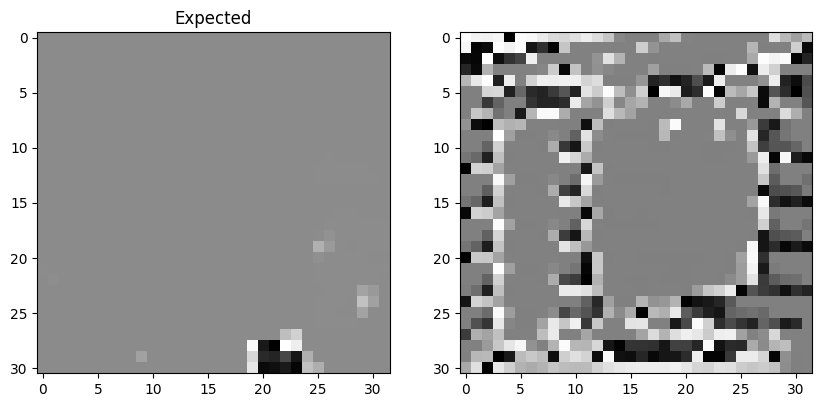

In [9]:
img_expected = []
img_read = []
for lines in uc_output.splitlines():
    data = lines.split('Expected ')[1]
    expected = int(data.split(', read ')[0], 16)
    read = int(data.split(', read ')[1][:-1], 16)
    
    img_expected.append(expected)
    img_read.append(read)
    
    
print(len(img_read))
    
img_expected = np.array(img_expected)[:992].reshape(31, 32)
img_read = np.array(img_read)[:992].reshape(31, 32)

#plot em
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_expected, cmap='gray')
plt.title('Expected')
plt.subplot(1, 2, 2)
plt.imshow(img_read, cmap='gray')